# Installation des librairies requis

In [1]:
!pip install --upgrade pip -q
!pip install -r ../requirements.txt -q

# Importation des librairies

In [2]:
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

# Chargement des images

La cellule de code ci-dessous est à exécuter seulement si on a plusieurs accès au dataset stocké

In [3]:
if not os.path.exists("../data/liste_datasets.joblib"):
    path = '../data/COVID-19_Radiography_Dataset/'
    Liste = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']
    imgdataset = []
    maskdataset = []
    labels = []

    for index, name in enumerate(Liste):
        
        for dirname, _, filenames in os.walk(path + name + "/images"):
            n = len(filenames)
            print("found ",n," images and masks in ", name, " folder")
            
            imgdataset+= [cv2.imread(os.path.join(dirname, file), 0) for file in filenames]                                 
            labels+= [index for i in range(n)]
            
        for dirname, _, filenames in os.walk(path + name + "/masks"):  

            maskdataset+= [cv2.imread(os.path.join(dirname, file), 0) for file in filenames]

    imgdataset = np.array(imgdataset)
    maskdataset = np.array(maskdataset)
    labels = np.array(labels)
    liste_datasets = [imgdataset, labels, maskdataset]

    dump(liste_datasets, '../data/liste_datasets.joblib')

found  3616  images and masks in  COVID  folder
found  10192  images and masks in  Normal  folder
found  6012  images and masks in  Lung_Opacity  folder
found  1345  images and masks in  Viral Pneumonia  folder


In [4]:
liste_datasets = load('../data/liste_datasets.joblib')
imgdataset = liste_datasets[0]
labels = liste_datasets[1]
maskdataset = liste_datasets[2]
Liste = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']

# Création d'un dataset contenant les labels et les sources

In [5]:
#ajout au précédent dataframe des métadonnées de chaque classe, en particulier les URLs de source de données"

df = pd.DataFrame(data = {'labels' : [Liste[lab] for lab in labels]})

path = '../data/COVID-19_Radiography_Dataset/'
dfmeta = pd.read_excel(path + 'COVID.metadata.xlsx')
dfmeta = pd.concat([dfmeta,pd.read_excel(path + 'Normal.metadata.xlsx')])
dfmeta = pd.concat([dfmeta,pd.read_excel(path + 'Lung_Opacity.metadata.xlsx')])
dfmeta = pd.concat([dfmeta,pd.read_excel(path + 'Viral Pneumonia.metadata.xlsx')])

dfmeta = dfmeta.reset_index()


# labels = ["bimcv.cipf.es", "eurorad.org", "armiro", "ieee8023", "ml-workgroup", "senza-categoria"]

df['URL'] = dfmeta['URL'].replace(['https://sirm.org/category/senza-categoria/covid-19/',
       'https://github.com/ml-workgroup/covid-19-image-repository/tree/master/png',
       'https://eurorad.org', 'https://github.com/armiro/COVID-CXNet',
       'https://github.com/ieee8023/covid-chestxray-dataset',
       'https://bimcv.cipf.es/bimcv-projects/bimcv-covid19/#1590858128006-9e640421-6711',
       'https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data',
       'https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia'], ['https://sirm.org', 'https://github.com/ml-workgroup', 'https://eurorad.org', 'https://github.com/armiro','https://github.com/ieee8023','https://bimcv.cipf.es','https://www.kaggle.com/c','https://www.kaggle.com/paultimothymooney'])


# Fonctions utiles

La fonction show_images prend en entrée les données d'images, les données des masques, le titre pour enregistrer l'image et un booleen pour savoir si l'image est normalisé ou pas. Elle affiche plusieurs images et masques dans un même graphique en utilisant la bibliothèque Matplotlib. Les images affichées sont sélectionnées aléatoirement parmi les différentes catégories de l'ensemble de données. Les images affichées incluent les images originales, les masques associés à ces images, les images avec les contours des masques et les images avec les masques superposés. Cela permet de visualiser comment les masques sont appliqués aux images et comment ils peuvent être utilisés pour mettre en évidence certaines caractéristiques de ces images.

In [6]:
def show_images(img_dat, mask_dat, title_img, normalize=False):
    """
    Cette fonction permet d'afficher des images avec leurs masques.

    Parameters:
        img_dat:    Données d'images
        mask_dat:   Données de masque
        title_img:  Titre de l'image à enregistrer
        normalize:  Boolen (image normalisé ou pas)

    Returns:
        None
    """
    for img_type in Liste:
        # Initialisation de la figure avec des sous-images disposées en grille (3 lignes x 4 colonnes)
        fig, axs = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(52,40))
        
        # Titre de la figure
        if normalize:
            fig.suptitle(f"Images {img_type} normalisées", color='b', fontweight='bold', fontsize=60, y=1);
        else:
            fig.suptitle(f"Images {img_type}", color='b', fontweight='bold', fontsize=60, y=1);
        
        # Couleur de fond de la figure
        fig.patch.set_facecolor('lavender')
        
        # Masquage des axes x et y
        plt.xticks([])
        plt.yticks([])
        
        # Selection des indexes des images correspondant au type dans le dataframe 'df'
        index = df[df['labels'] == img_type].index
        
        # Calcule de la valeur moyenne pour chaque image correspondant
        moy = np.mean(img_dat[index], axis= (1,2))        
        # Trouve l'index de l'image la plus foncée
        mini = index[np.argmin(moy)]
        # Trouve l'index de l'image moyenne
        diffs = np.abs(moy - moy.mean())
        moyen = index[np.argmin(diffs)]
        # Trouve l'index de l'image la plus claire
        maxi = index[np.argmax(moy)]

        # Image la plus foncée
        image = img_dat[mini]
        axs[0,0].imshow(image, cmap = 'gray')
        axs[0,0].set_title("Image", fontsize=40, color='darkgreen', fontweight='bold')
        axs[0,0].set_ylabel("Image la plus foncée", color='m', rotation=0, fontsize=50, ha='right', fontweight='bold')
        
        axs[0,1].imshow(mask_dat[mini],cmap = 'gray')
        axs[0,1].set_title("Masque", fontsize=40, color='darkgreen', fontweight='bold')
        
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        contours, hierarchy = cv2.findContours(mask_dat[mini], cv2.RETR_EXTERNAL, 2)
        masked =  cv2.drawContours(image.copy(), contours, -1, (100,255, 100),2)
        axs[0,2].imshow(masked,cmap = 'gray')
        axs[0,2].set_title("Image + contour du masque", fontsize=40, color='darkgreen', fontweight='bold')

        masked = cv2.bitwise_and(image, image, mask=mask_dat[mini])
        axs[0,3].imshow(masked,cmap = 'gray')
        axs[0,3].set_title("Image + masque", fontsize=40, color='darkgreen', fontweight='bold')
        

        # Image normale
        image = img_dat[moyen]
        axs[1,0].imshow(image, cmap = 'gray')
        axs[1,0].set_title("Image", fontsize=40, color='darkgreen', fontweight='bold')
        axs[1,0].set_ylabel("Image moyenne", color='m', rotation=0, fontsize=50, ha='right', fontweight='bold')
        
        axs[1,1].imshow(mask_dat[moyen],cmap = 'gray')
        axs[1,1].set_title("Masque", fontsize=40, color='darkgreen', fontweight='bold')
        
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        contours, hierarchy = cv2.findContours(mask_dat[moyen], cv2.RETR_EXTERNAL, 2)
        masked =  cv2.drawContours(image.copy(), contours, -1, (100,255, 100),2)
        axs[1,2].imshow(masked,cmap = 'gray')
        axs[1,2].set_title("Image + contour du masque", fontsize=40, color='darkgreen', fontweight='bold')

        masked = cv2.bitwise_and(image, image, mask=mask_dat[moyen])
        axs[1,3].imshow(masked,cmap = 'gray')
        axs[1,3].set_title("Image + masque", fontsize=40, color='darkgreen', fontweight='bold')
        
        # Image la plus claire
        image = img_dat[maxi]
        axs[2,0].imshow(image, cmap = 'gray')
        axs[2,0].set_title("Image", fontsize=40, color='darkgreen', fontweight='bold')
        axs[2,0].set_ylabel("Image la plus claire", color='m', rotation=0, fontsize=50, ha='right', fontweight='bold')
        
        
        axs[2,1].imshow(mask_dat[maxi],cmap = 'gray')
        axs[2,1].set_title("Masque", fontsize=40, color='darkgreen', fontweight='bold')
        
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        contours, hierarchy = cv2.findContours(mask_dat[maxi], cv2.RETR_EXTERNAL, 2)
        masked =  cv2.drawContours(image.copy(), contours, -1, (100,255, 100),2)
        axs[2,2].imshow(masked,cmap = 'gray')
        axs[2,2].set_title("Image + contour du masque", fontsize=40, color='darkgreen', fontweight='bold')
        
        masked = cv2.bitwise_and(image, image, mask=mask_dat[maxi])
        axs[2,3].imshow(masked,cmap = 'gray')
        axs[2,3].set_title("Image + masque", fontsize=40, color='darkgreen', fontweight='bold')

        # Mise en forme des figures
        fig.tight_layout(h_pad=-8)
    
        # Enregistrement de la figure en image
        plt.savefig(f"../images/{title_img}_{img_type}.png", bbox_inches="tight")

        # Affichage de la figure
        plt.show()
        print()

La fonction show_dist_pixel montre les distributions des valeurs de pixels pour des images aléatoires sélectionnées pour chaque catégorie d'image. Elle utilise une boîte à moustaches pour afficher ces distributions. La boîte à moustaches montre la répartition des valeurs de pixels pour chaque image sélectionnée aléatoirement. Les différentes catégories d'images sont affichées à l'aide d'une légende sur le côté droit du graphique. Cela permet de comparer les distributions de valeurs de pixels pour différentes catégories d'images.

In [7]:
def show_dist_pixel(dataset, title,  title_img, nb_images=2):
    """
    Cette fonction permet d'afficher des images avec leurs masques.

    Parameters:
        dataset:    Données de l'image
        title:      Titre du graphique
        title_img:  Titre de l'image à enregistrer
        nb_images:  Nombre d'images pour chaque catégorie

    Returns:
        None
    """
    
    dataset = pd.DataFrame(np.array(dataset).reshape(21165,-1))
    dataset['labels'] = df['labels']
        
    # Initialisation des listes pour stocker les catégories, labels et valeurs de pixels
    cats = []
    labs = []
    pix = []
    id = 1

    # Boucle sur chaque type d'image dans la liste
    for sp in Liste:
        # Sélectionne les données de l'image correspondante dans le dataset
        tmp = dataset[dataset['labels'] == sp]
        # Boucle pour sélectionner le nombre d'images aléatoires spécifié
        for i in range(nb_images):
            randindex = np.random.randint(len(tmp))
            # Ajout des valeurs de pixels, labels et catégories aux listes respectives
            pix.append(tmp.iloc[randindex,:-1].tolist())
            lab = np.empty(len(tmp.columns) - 1, dtype='O')
            lab.fill(f'Image {id}')
            labs.append(lab) 
            cat = np.empty(len(tmp.columns) - 1, dtype='O')
            cat.fill(tmp.iloc[randindex, -1])
            cats.append(cat)
            id+=1

    # Conversion des listes en tableaux numpy pour les utiliser dans un dataframe
    pix = np.array(pix).reshape(-1).squeeze().tolist()
    labs = np.array(labs).reshape(-1).squeeze().tolist()
    cats = np.array(cats).reshape(-1).squeeze().tolist()

    # Création d'un dataframe pour stocker les données
    d = pd.DataFrame({'Categorie':cats, 'labels':labs, 'pix':pix})
    d.sort_values(by='Categorie')

    # Création d'une figure
    fig = plt.figure(figsize=(40,10))

    # Création du graphique de type boîte à moustaches à l'aide de seaborn
    g = sns.catplot(data=d, x='labels', y='pix', hue='Categorie', kind='box', height=10, aspect=2)
    # Déplacement de la légende vers la droite
    sns.move_legend(g, None, bbox_to_anchor=(1.06, .5), title="GATEGORIES", fontsize=18, title_fontsize=32, frameon=False)

    g.fig.set_facecolor("lavender")
    g.ax.set_facecolor('lightcyan')
    
    # Configuration du titre du graphique
    plt.title(title + '\n', color='b', fontsize=30, fontweight='bold')
    # Rotation des étiquettes des images sur l'axe des x
    plt.xticks(rotation=90, fontsize=15)
    plt.yticks(fontsize=15)
    # Configuration de l'étiquette de l'axe des x
    plt.xlabel("Images aleatoire", fontsize=25, color='m')
    # Configuration de l'étiquette de l'axe des y
    plt.ylabel("Valeur du pixel", fontsize=25, color='m')
    # Configuration de la couleur de la légende
    plt.setp(g._legend.get_title(), color='b')

    # Enregistrement de la figure en image
    plt.savefig(f"../images/{title_img}.png", bbox_inches="tight")

    # Affichage de la figure
    plt.show()

La fonction sow_images_with_mask affiche 5 images avec leurs masques sur une même ligne en utilisant matplotlib. Elle prend en entrée un titre pour le graphique, les données des masques et le titre de l'image à enregistrer. Elle retourne None. La figure est créée en utilisant imshow, les axes sont cachés et un curseur de couleur est ajouté en bas. Enfin, la figure est enregistrée en tant qu'image PNG et affichée

In [8]:
def sow_images_with_mask(title, masked, title_img):
    """
    Afficher des images avec leur masque.

    Paramètres:
        title :     Titre du graphique
        masked :    Données des masques
        title_img : Titre de l'image à enregistrer

    Retour :
        None
    """
    # Créer 5 figures sur une seule ligne
    fig, axs = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(25,5))
    for i in range(5):
        image = masked[i]
        axs[i].imshow(image, cmap='gray', vmin=0, vmax=255)

    plt.xticks([])
    plt.yticks([])
    cbar = fig.colorbar(axs[0].imshow(image, cmap='gray', vmin=0, vmax=255), ax=axs.ravel().tolist(), location='bottom')
    cbar.ax.set_xticks([0, 255*.25, 255*0.5, 255*.75, 255], ['0%', '25%', '50%', '75%', '100%'], fontsize=10)
    fig.patch.set_facecolor('lavender')
    plt.suptitle(title + "\n", color='b', fontsize='25', fontweight='bold')

    # Enregistrement de la figure en image
    plt.savefig(f"../images/{title_img}.png", bbox_inches="tight")

    # Afficher la figure
    plt.show()


La fonction affichage prend en entrée un tableau d'images, un tableau de masques, un tableau d'images masquées, un tableau de labels et le nombre d'image à afficher. Elle affiche aléatoirement (selon le nombre donné) des exemples d'images de chaque catégorie avec leur masque correspondant et leur image masquée. Les images sont affichées côte à côte dans une même figure avec des titres explicatifs et une barre de couleur pour indiquer la luminosité des pixels. La fonction permet de visualiser de manière claire les données d'entrée et de faciliter l'analyse des images.

In [9]:
def affichage(imagesarray, maskarray, imagemaskarray, labelsarray, nb=1):
    """
    Cette fonction permet d'afficher des exemples d'images avec leurs masques et les images avec leur masque appliqué.
    
    Parameters:
        imagesarray:    Données d'images en niveaux de gris.
        maskarray:      Données des masques correspondants aux images.
        imagemaskarray: Données des images avec leur masque appliqué.
        labelsarray:    Données des labels correspondant à chaque image.
        nb (int):       Nombre d'exemples d'images à afficher.
    
    Returns:
        None
    """
    Liste = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']
    for i in range(nb):
        for type_img in Liste:
            index = df[df['labels'] == type_img].index
            randindex = index[np.random.randint(len(index))]
            print("categorie : ", type_img)
            fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(20,5))
    #         axs[0].imshow(imagesarray[randindex], cmap='gray');
            axs[1].imshow(maskarray[randindex], cmap = 'gray');
            axs[2].imshow(imagemaskarray[randindex],cmap = 'gray');

            plt.xticks([])
            plt.yticks([])
            fig.patch.set_facecolor('lavender')
            plt.suptitle(f"Exemple d'images de la catégorie: {labelsarray[randindex]}\n" , color='b', fontsize='25', fontweight='bold')

            cbar = fig.colorbar(axs[0].imshow(imagesarray[randindex], cmap='gray', vmin=0, vmax=255), ax=axs.ravel().tolist(), location='bottom', shrink=0.30)
            cbar.set_label("Lumninosite des pixels", fontsize=10)
            cbar.ax.set_xticks([0, 255*.25, 255*0.5, 255*.75, 255], ['0%', '25%', '50%', '75%', '100%'], fontsize=10)

            # Enregistrement de la figure en image
            plt.savefig(f"../images/rendu_final_{type_img}.png", bbox_inches="tight")

            # Affichage de la figure
            plt.show()

La fonction normalize_intensity prend en entrée une liste d'images. Pour chaque image dans cette liste, elle utilise l'histogramme égalisé de OpenCV pour normaliser l'intensité de l'image. L'histogramme égalisé est une technique d'ajustement de contraste qui permet d'égaliser la répartition des niveaux de gris dans l'image. Cela peut améliorer la qualité de l'image en augmentant le contraste et en réduisant le bruit. La fonction renvoie ensuite une liste d'images normalisées.

In [10]:
def normalize_intensity(images):
    """
    Cette fonction normalise l'intensité des images en utilisant l'histogramme égalisé de OpenCV

    Parameters:
        images: Liste d'images

    return:
        Données d'images normalisées
    """
    normalized_images = []
    for image in images:
        # Convertir l'image en niveaux de gris si elle est en couleur
        if len(image.shape)>2:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Appliquer l'histogramme égalisé pour normaliser l'intensité
        image_eq = cv2.equalizeHist(image)
#         image_med = cv2.medianBlur(image_eq, ksize=3)
        # Ajouter l'image normalisée à la liste
        normalized_images.append(image_eq)
    return np.array(normalized_images)

# Infos du dataset

La cellule de code ci-dessous donne une représentation graphique de la proportion d'images en fonction de la source pour chaque élément de la liste donnée, où chaque sous-graphique représente un élément de la liste. Les sections du graphique circulaire sont colorées en fonction de la source de l'image, et un pourcentage est affiché pour chaque section. La légende donne les sources correspondantes pour chaque couleur utilisée dans les graphiques. La figure donne une vision globale de la répartition des images en fonction de leur source pour chaque élément de la liste donnée.

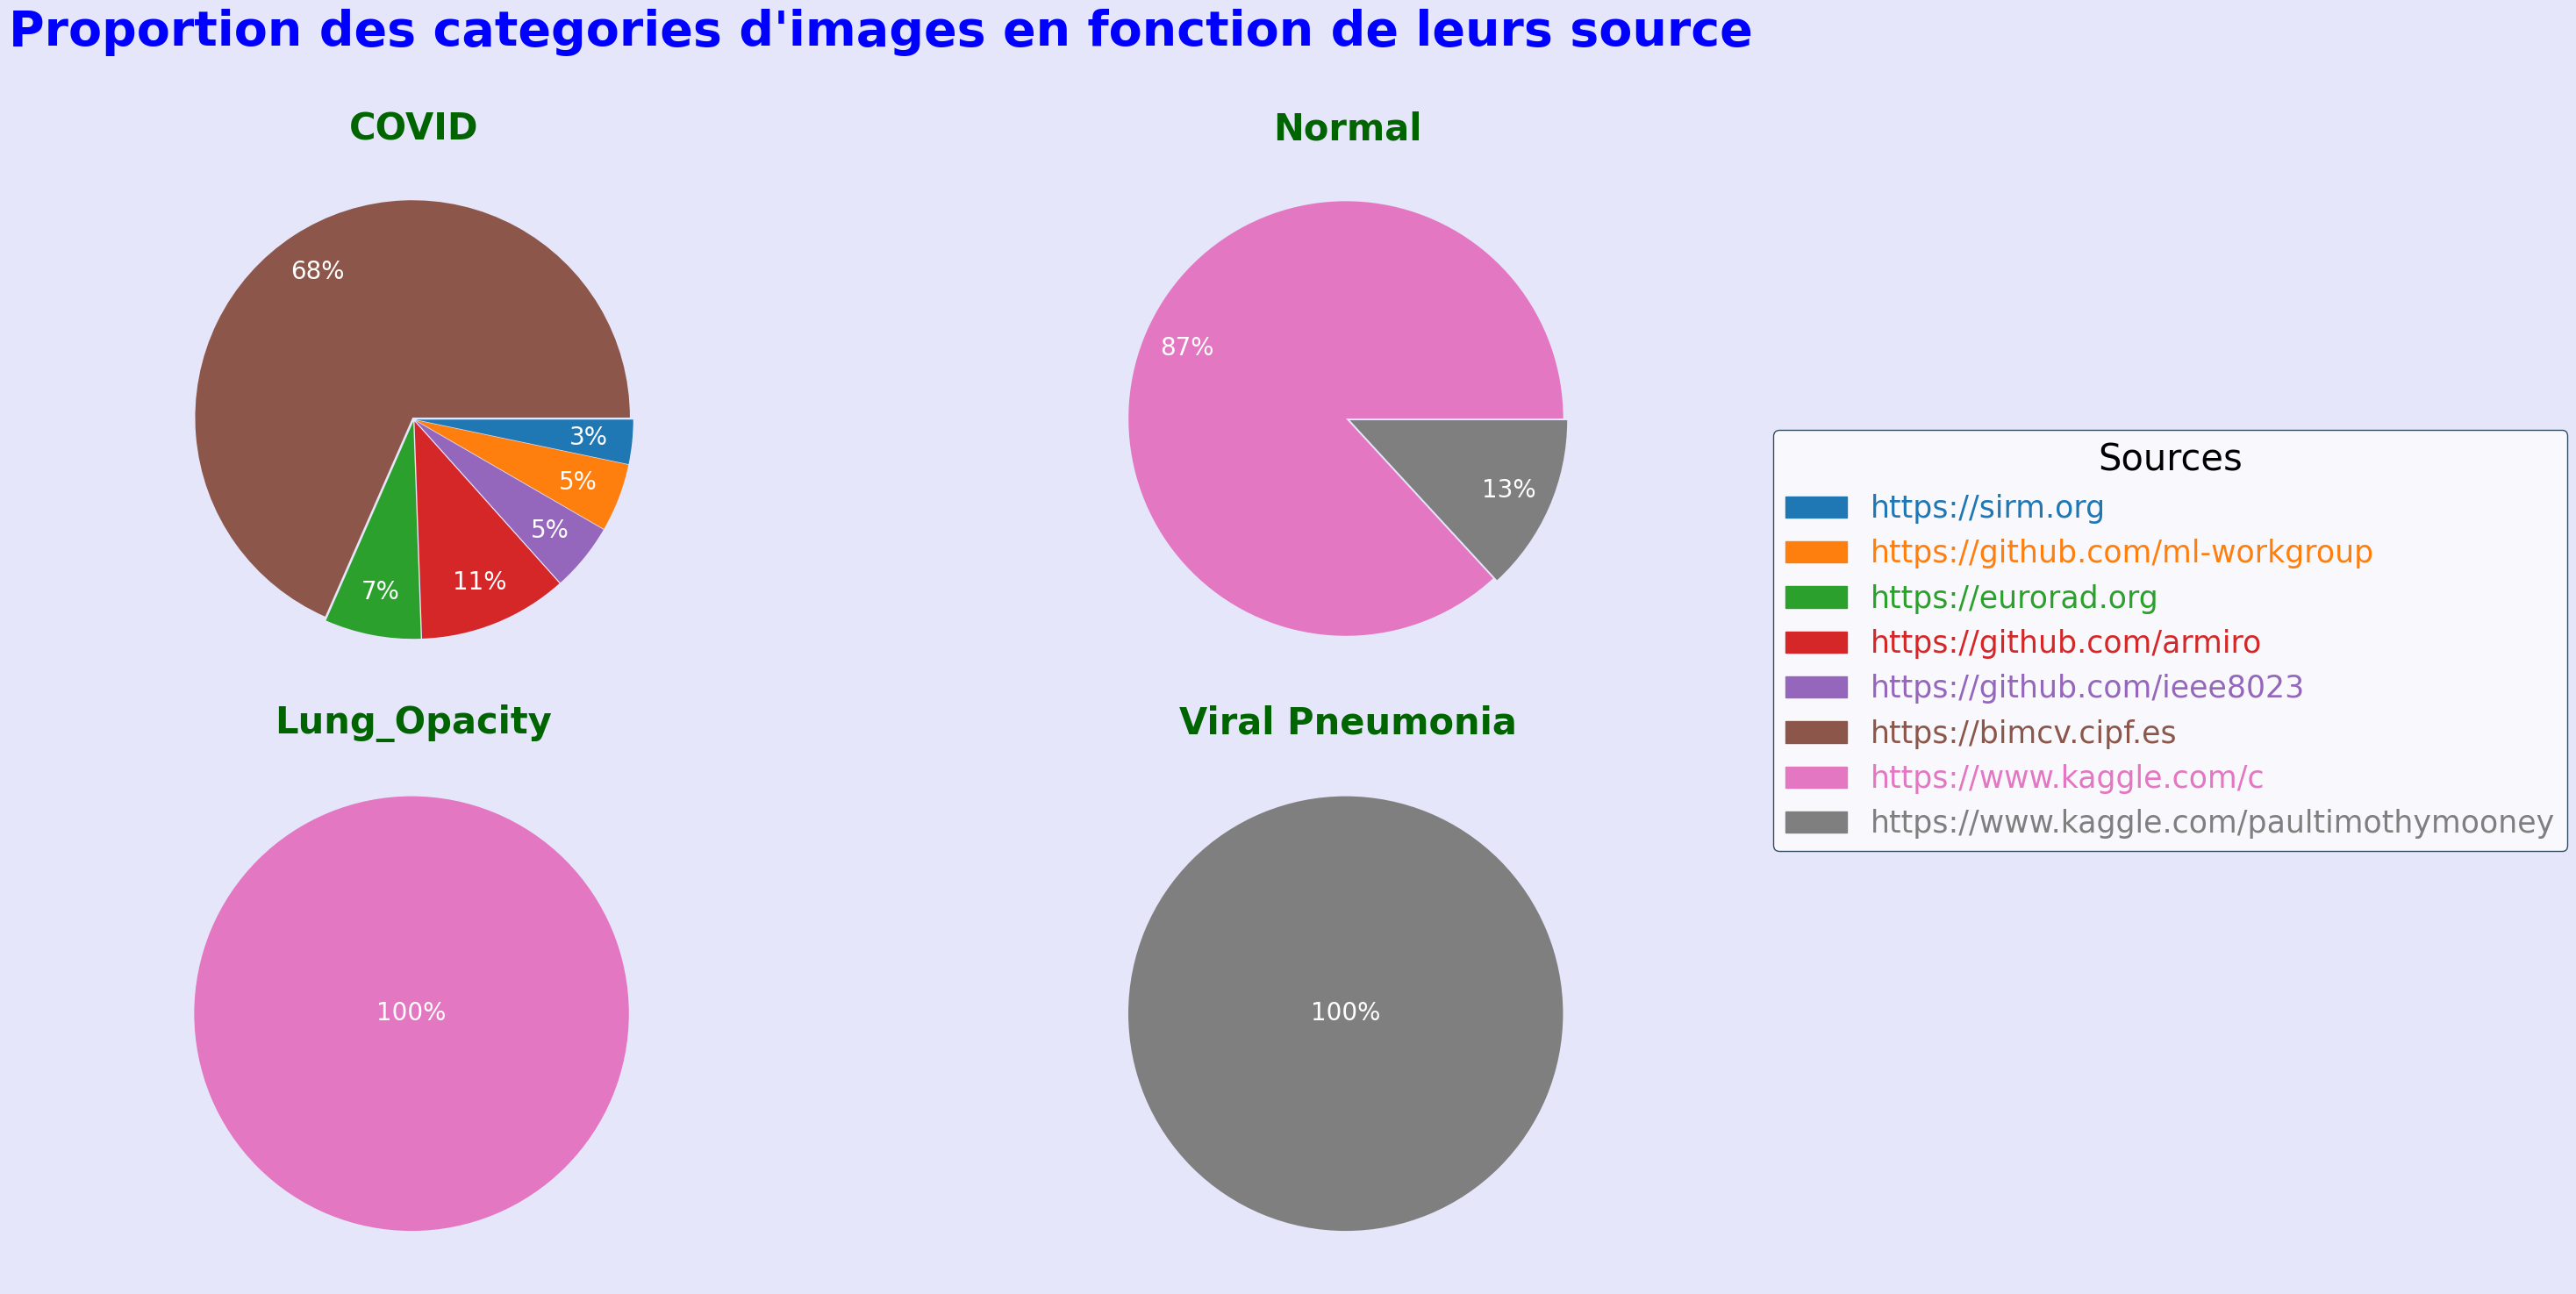

In [11]:
# Création d'une figure avec 4 sous-graphiques disposés en grille 2x2
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(25,15))

# On regroupe les sous-graphiques en un tableau en 1 dimmension
axs = axs.flatten()

# Dictionnaire pour associer les URL uniques à des couleurs
dic = {}
for a, b in zip(df['URL'].unique(), sns.color_palette()):
    dic[a] = b

# Boucle pour créer les graphiques pour chaque élément de la liste 'Liste'
for i in range(len(Liste)):
    # Sélection des lignes du DataFrame correspondant à l'élément en cours de la liste
    df_tmp = df[df['labels'] == Liste[i]]
    # Regroupement des données par URL et comptage des occurrences
    df_tmp = df_tmp.groupby('URL')['URL'].count()

    # Utilisation des couleurs du dictionnaire pour les sections du graphique
    colors = df_tmp.rename(dic).index
    
    # Séparation entre les sections pour une meilleure lisibilité
    expl = np.empty(len(df_tmp.index))
    expl.fill(0.01)
    # Création du graphique en utilisant les propriétés spécifiées
    if i >= 2:
        patches, texts, pcts = axs[i].pie(df_tmp, colors=colors, autopct='%.0f%%', textprops={'fontsize': 12}, pctdistance=0, labeldistance=-1.02, explode=expl)
    else:
        patches, texts, pcts = axs[i].pie(df_tmp, colors=colors, autopct='%.0f%%', textprops={'fontsize': 12}, pctdistance=0.8, labeldistance=1.02, explode=expl)
    # Ajout d'un titre pour chaque sous-graphique
    axs[i].set_title(Liste[i], color='darkgreen', size=30, fontweight="bold")
    
    # Mise en forme des étiquettes de pourcentage
    for i, patch in enumerate(patches):
        texts[i].set_color(patch.get_facecolor())
    plt.setp(texts, fontsize=15)
    plt.setp(pcts, color='white', fontsize=20)

# Création de la légende à partir des entrées du dictionnaire
handles = [plt.Rectangle((0, 0), 0, 0, color=b, label=a) for a, b in dic.items()]
l = fig.legend(handles=handles,
        title="Sources",
        loc="center left",
        fontsize=25,
        facecolor='w',
        edgecolor="#04253a",
        bbox_to_anchor=(0.9, 0, 0.5, 1))

# Mise en forme de la légende, les textes ont la couleur de la source correspondante
for text in l.get_texts():
    text.set_color(dic[text.get_text()])

# Mise en forme de la légende, la taille de police et la couleur du titre
title = l.get_title()
title.set_fontsize(30)
title.set_color('black')
    
# Modification de la couleur d'arrière-plan de la figure
fig.patch.set_facecolor('lavender') 

# Ajout d'un titre à la figure
fig.suptitle("Proportion des categories d'images en fonction de leurs source\n", color='b', fontsize='40', fontweight="bold")

plt.tight_layout()

# Enregistrement de la figure en image
plt.savefig("../images/proporsion_sources.png", bbox_inches="tight")

# Affichage de la figure
plt.show()

**On voit tres clairement que les images du covid proviennent de plusieurs sources sauf 3**  
 . `c` qui ne contient que des images **Normal et Lung_Opacity** (Dont il est la source exclusif)  
 . `paultimothymooney` qui ne contient que des images **Normal et Viral Pneumonia** (Dont il est la source exclusif)

La cellule de code ci-dessous donne une representation graphique de la proportion des différents types d'images en utilisant les données de la variable 'labels', où chaque section du graphique circulaire représente un type d'image différent. Les sections du graphique sont colorées en fonction du type d'image et un pourcentage est affiché pour chaque section. La figure donne une vision globale de la répartition des images en fonction de leur type.

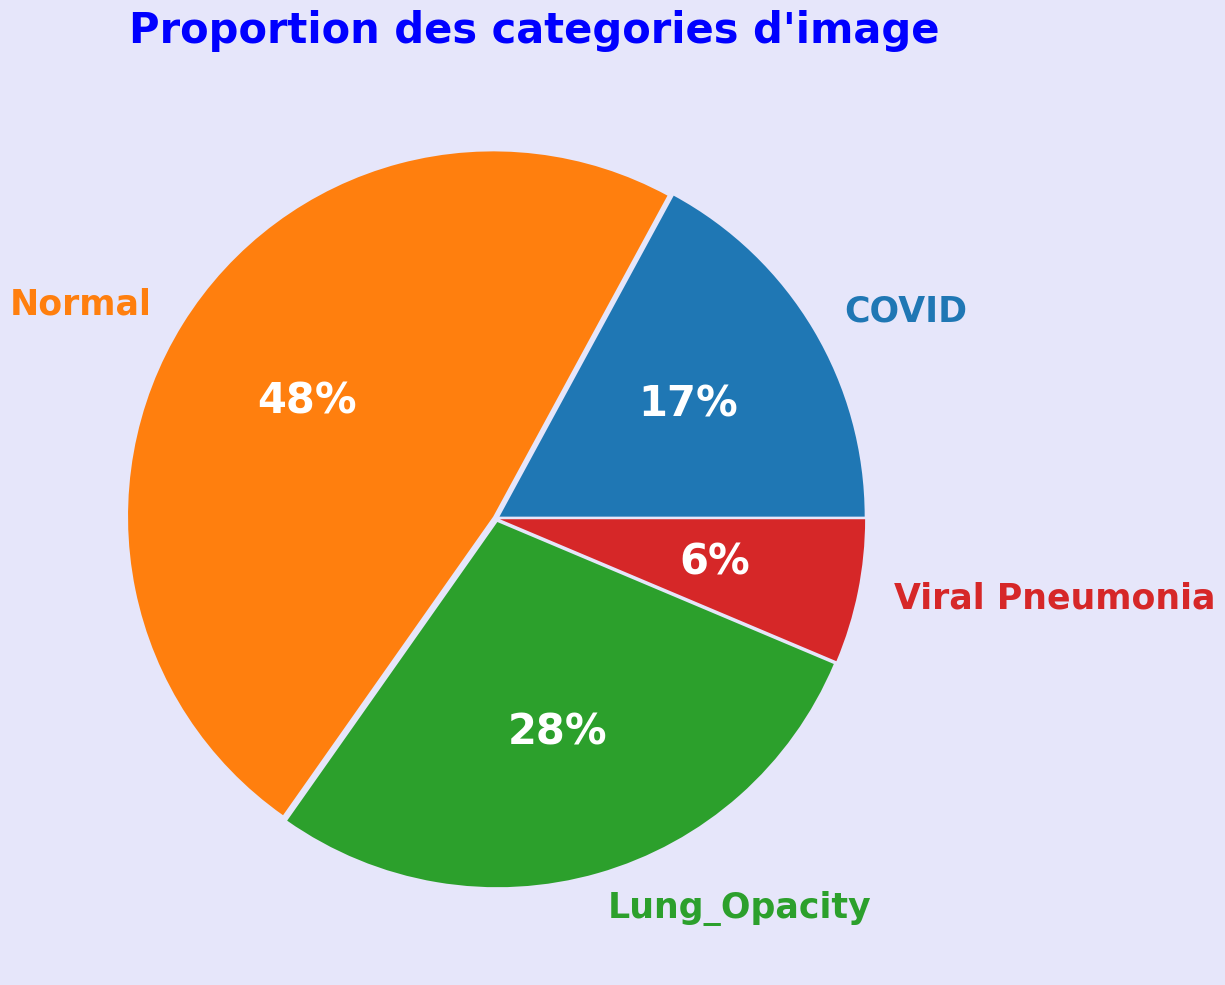

In [12]:
# Comptage des occurrences de chaque étiquette
X, counts = np.unique(labels, return_counts=True)

# Sélection des couleurs à utiliser pour les sections du graphique
colors = sns.color_palette()[0:4]

# Création de la figure
fig = plt.figure(figsize=(15,10))

# Création du graphique circulaire en utilisant les données de comptage et les propriétés spécifiées
patches, texts, pcts = plt.pie(counts, colors=colors, labels=Liste, autopct='%.0f%%', textprops={'fontsize': 25}, explode=[.01,.01,.01,.01])

# Mise en forme des étiquettes pour qu'elles correspondent à la couleur de la section correspondante
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
plt.setp(texts, fontweight=600)
plt.setp(pcts, color='white', fontsize=30, fontweight="bold")

# Ajout d'un titre à la figure
plt.suptitle("Proportion des categories d'image", color='b', fontsize='30', fontweight="bold")

# Modification de la couleur d'arrière-plan de la figure
fig.patch.set_facecolor('lavender')

plt.tight_layout()

# Enregistrement de la figure en image
plt.savefig("../images/proporsion_categories.png", bbox_inches="tight")

# Affichage de la figure
plt.show()


# Analyse de donnee avec preproscessing

La cellule de code ci-dessous montre une image radiographique et son masque correspondant côte à côte. Il permet de visualiser la différence de proportion entre les deux images. Cela peut être utile pour vérifier la qualité du masque généré pour l'image radiographique et pour identifier les zones qui ont été mal masquées. Cela peut également aider à identifier les différences entre les images d'entraînement et les images de test pour améliorer les performances des modèles d'apprentissage automatique.

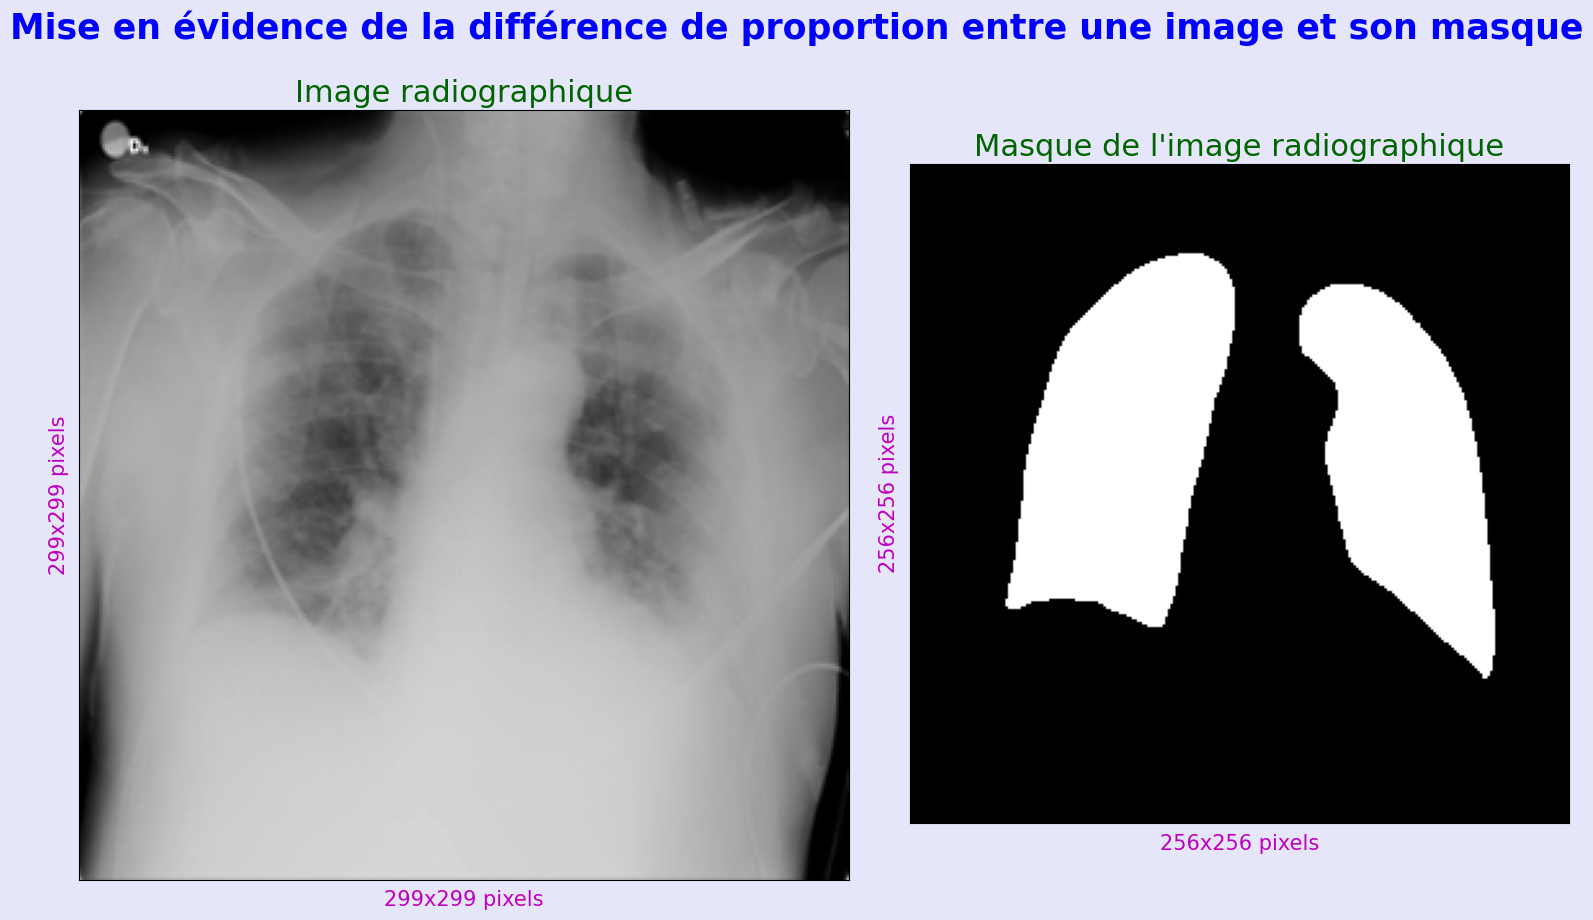

In [13]:
# Récupération de l'image radiographique et de son masque correspondant
image = imgdataset[0]
mask = maskdataset[0]

# Création de la figure
fig = plt.figure(figsize=(20,10))

# Création des sous-graphiques
ax1 = plt.subplot2grid((299, 555), (0, 0), rowspan=299, colspan=299)
ax2 = plt.subplot2grid((299, 555), (21, 299), rowspan=256, colspan=256)

# Affichage de l'image radiographique dans le premier sous-graphique
ax1.imshow(image, cmap='gray')
ax1.set_title("Image radiographique", color='darkgreen', fontsize=22)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel("299x299 pixels", color='m', fontsize=15)
ax1.set_ylabel("299x299 pixels", color='m', fontsize=15)

# Affichage du masque de l'image dans le deuxième sous-graphique
ax2.imshow(mask,cmap='gray')
ax2.set_title("Masque de l'image radiographique", color='darkgreen', fontsize=22)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel("256x256 pixels", color='m', fontsize=15)
ax2.set_ylabel("256x256 pixels", color='m', fontsize=15)

# Modification de la couleur d'arrière-plan de la figure
fig.patch.set_facecolor('lavender')

# Ajout d'un titre à la figure
plt.suptitle("Mise en évidence de la différence de proportion entre une image et son masque", color='b', fontweight='heavy', fontsize='25')

# Enregistrement de la figure en image
plt.savefig("../images/image299.png", bbox_inches="tight")
# Affichage de la figure
plt.show()


Il y a **21165** images de radio de dimmension **299x299**  
Il y a **21165** images de masque de dimmension **256x256**  
Ont devra donc **rimensionner** les images pour correspondres au masque

Le bloc ci-dessous permet de redimensionner les images.

In [14]:
# Redimensionnement du jeu de données d'images
imgdataset_resize = []

# Boucle sur toutes les images dans le jeu de données
for i in range(len(imgdataset)):
    # Ajout de l'image redimensionnée dans le nouveau tableau
    imgdataset_resize.append(cv2.resize(imgdataset[i], (256,256), interpolation= cv2.INTER_LINEAR))

# Conversion de la liste en tableau numpy
imgdataset_resize = np.array(imgdataset_resize)


La cellule de code ci-dessous montre une image radiographique redimensionnée et son masque correspondant côte à côte. Il permet de visualiser la différence de proportion entre les deux images. Cela peut être utile pour vérifier la qualité du masque généré pour l'image radiographique et pour identifier les zones qui ont été mal masquées. Cela peut également aider à identifier les différences entre les images d'entraînement et les images de test pour améliorer les performances des modèles d'apprentissage automatique.

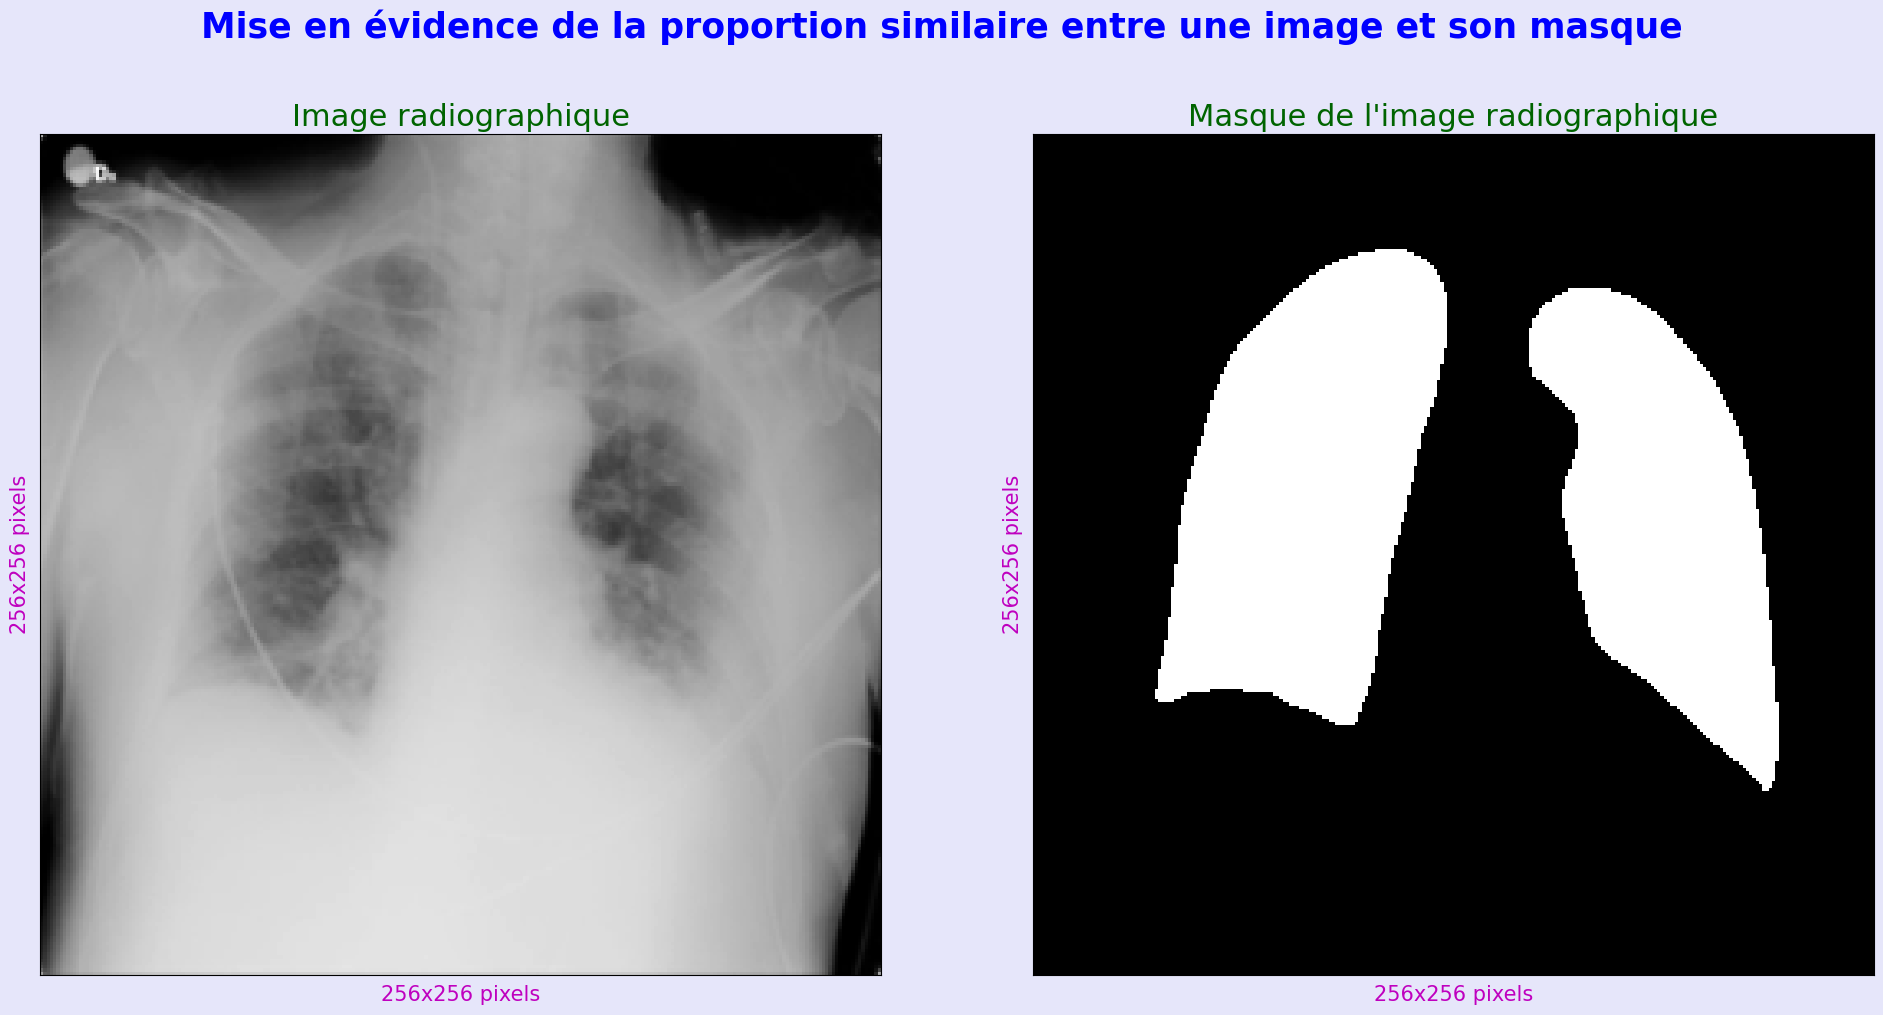

In [15]:
# Récupération de l'image radiographique rimensionnée et de son masque correspondant
image = imgdataset_resize[0]
mask = maskdataset[0]

# Création de la figure avec deux sous-graphiques côte à côte
fig, (ax1, ax2) = plt.subplots(figsize=(20,10), nrows=1, ncols=2)

# Affichage de l'image radiographique rimensionnée dans le premier sous-graphique
ax1.imshow(image, cmap='gray')
ax1.set_title("Image radiographique", color='darkgreen', fontsize=22)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel("256x256 pixels", color='m', fontsize=15)
ax1.set_ylabel("256x256 pixels", color='m', fontsize=15)

# Affichage du masque de l'image dans le deuxième sous-graphique
ax2.imshow(mask,cmap='gray')
ax2.set_title("Masque de l'image radiographique", color='darkgreen', fontsize=22)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel("256x256 pixels", color='m', fontsize=15)
ax2.set_ylabel("256x256 pixels", color='m', fontsize=15)
# Modification de la couleur d'arrière-plan de la figure
fig.patch.set_facecolor('lavender')

# Ajout d'un titre à la figure
plt.suptitle("Mise en évidence de la proportion similaire entre une image et son masque\n\n", color='b', fontweight='heavy', fontsize='25')

fig.tight_layout()

# Enregistrement de la figure en image
plt.savefig("../images/image256.png", bbox_inches="tight")

# Affichage de la figure
plt.show()

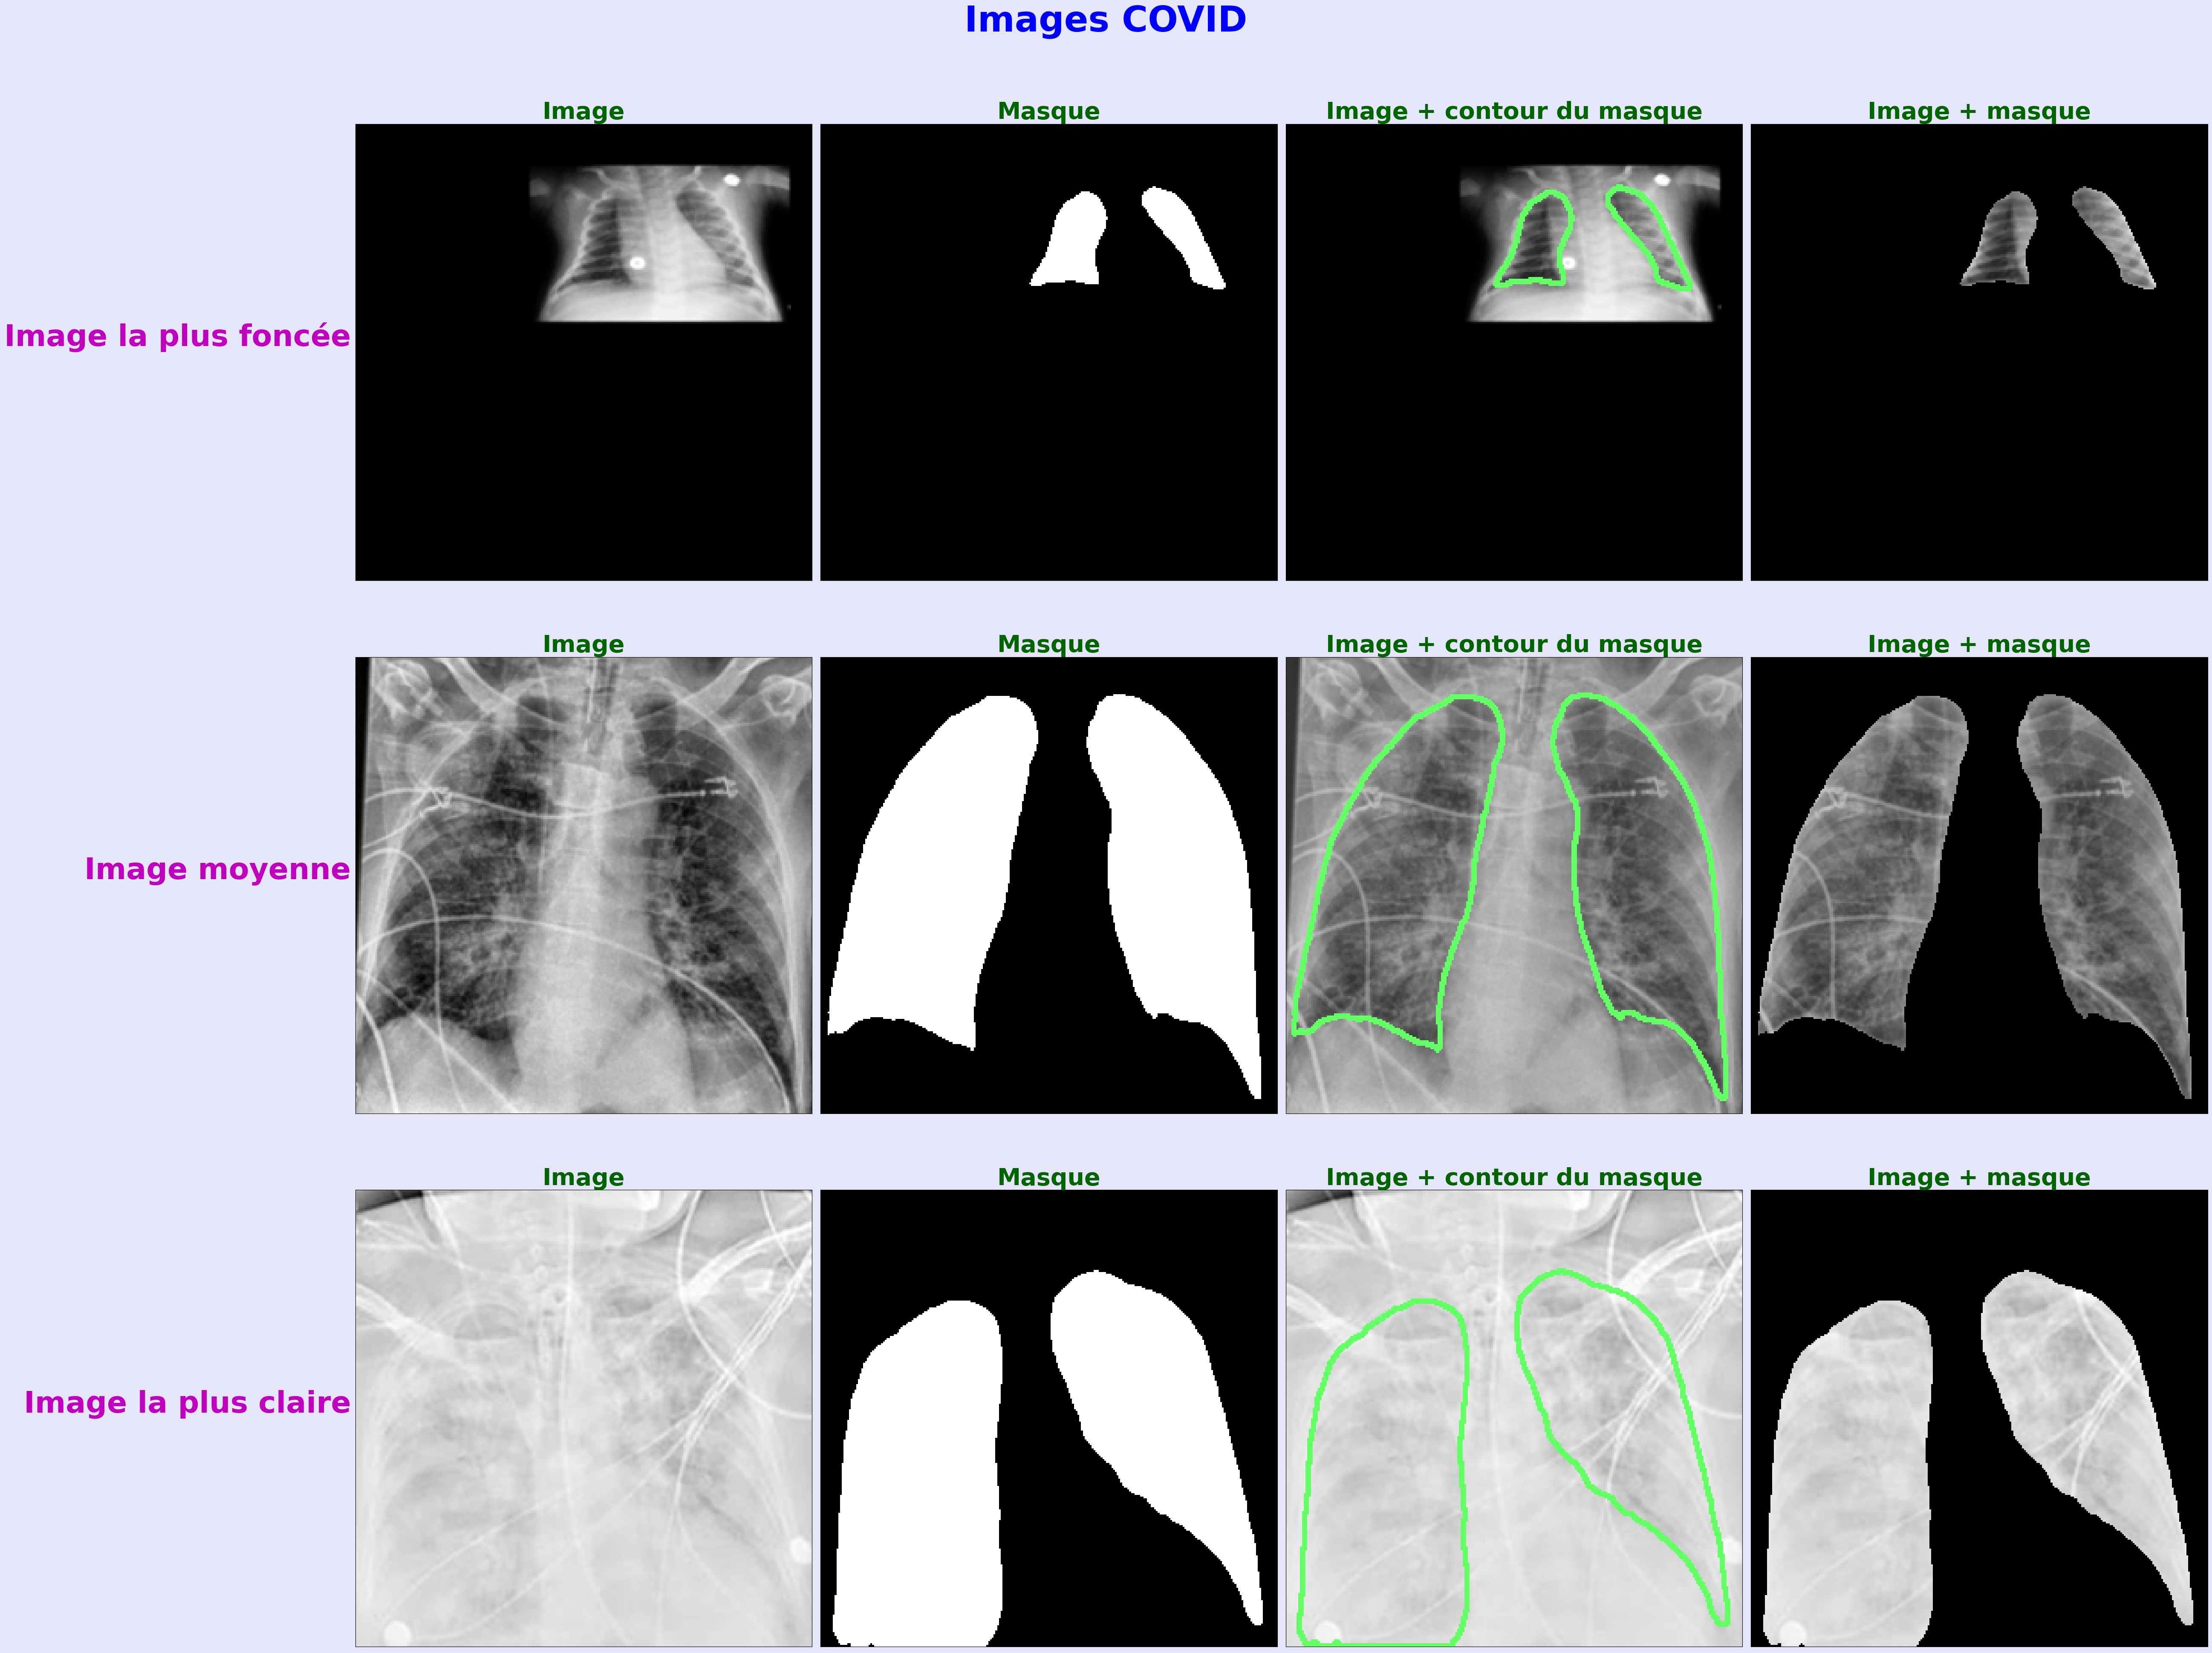

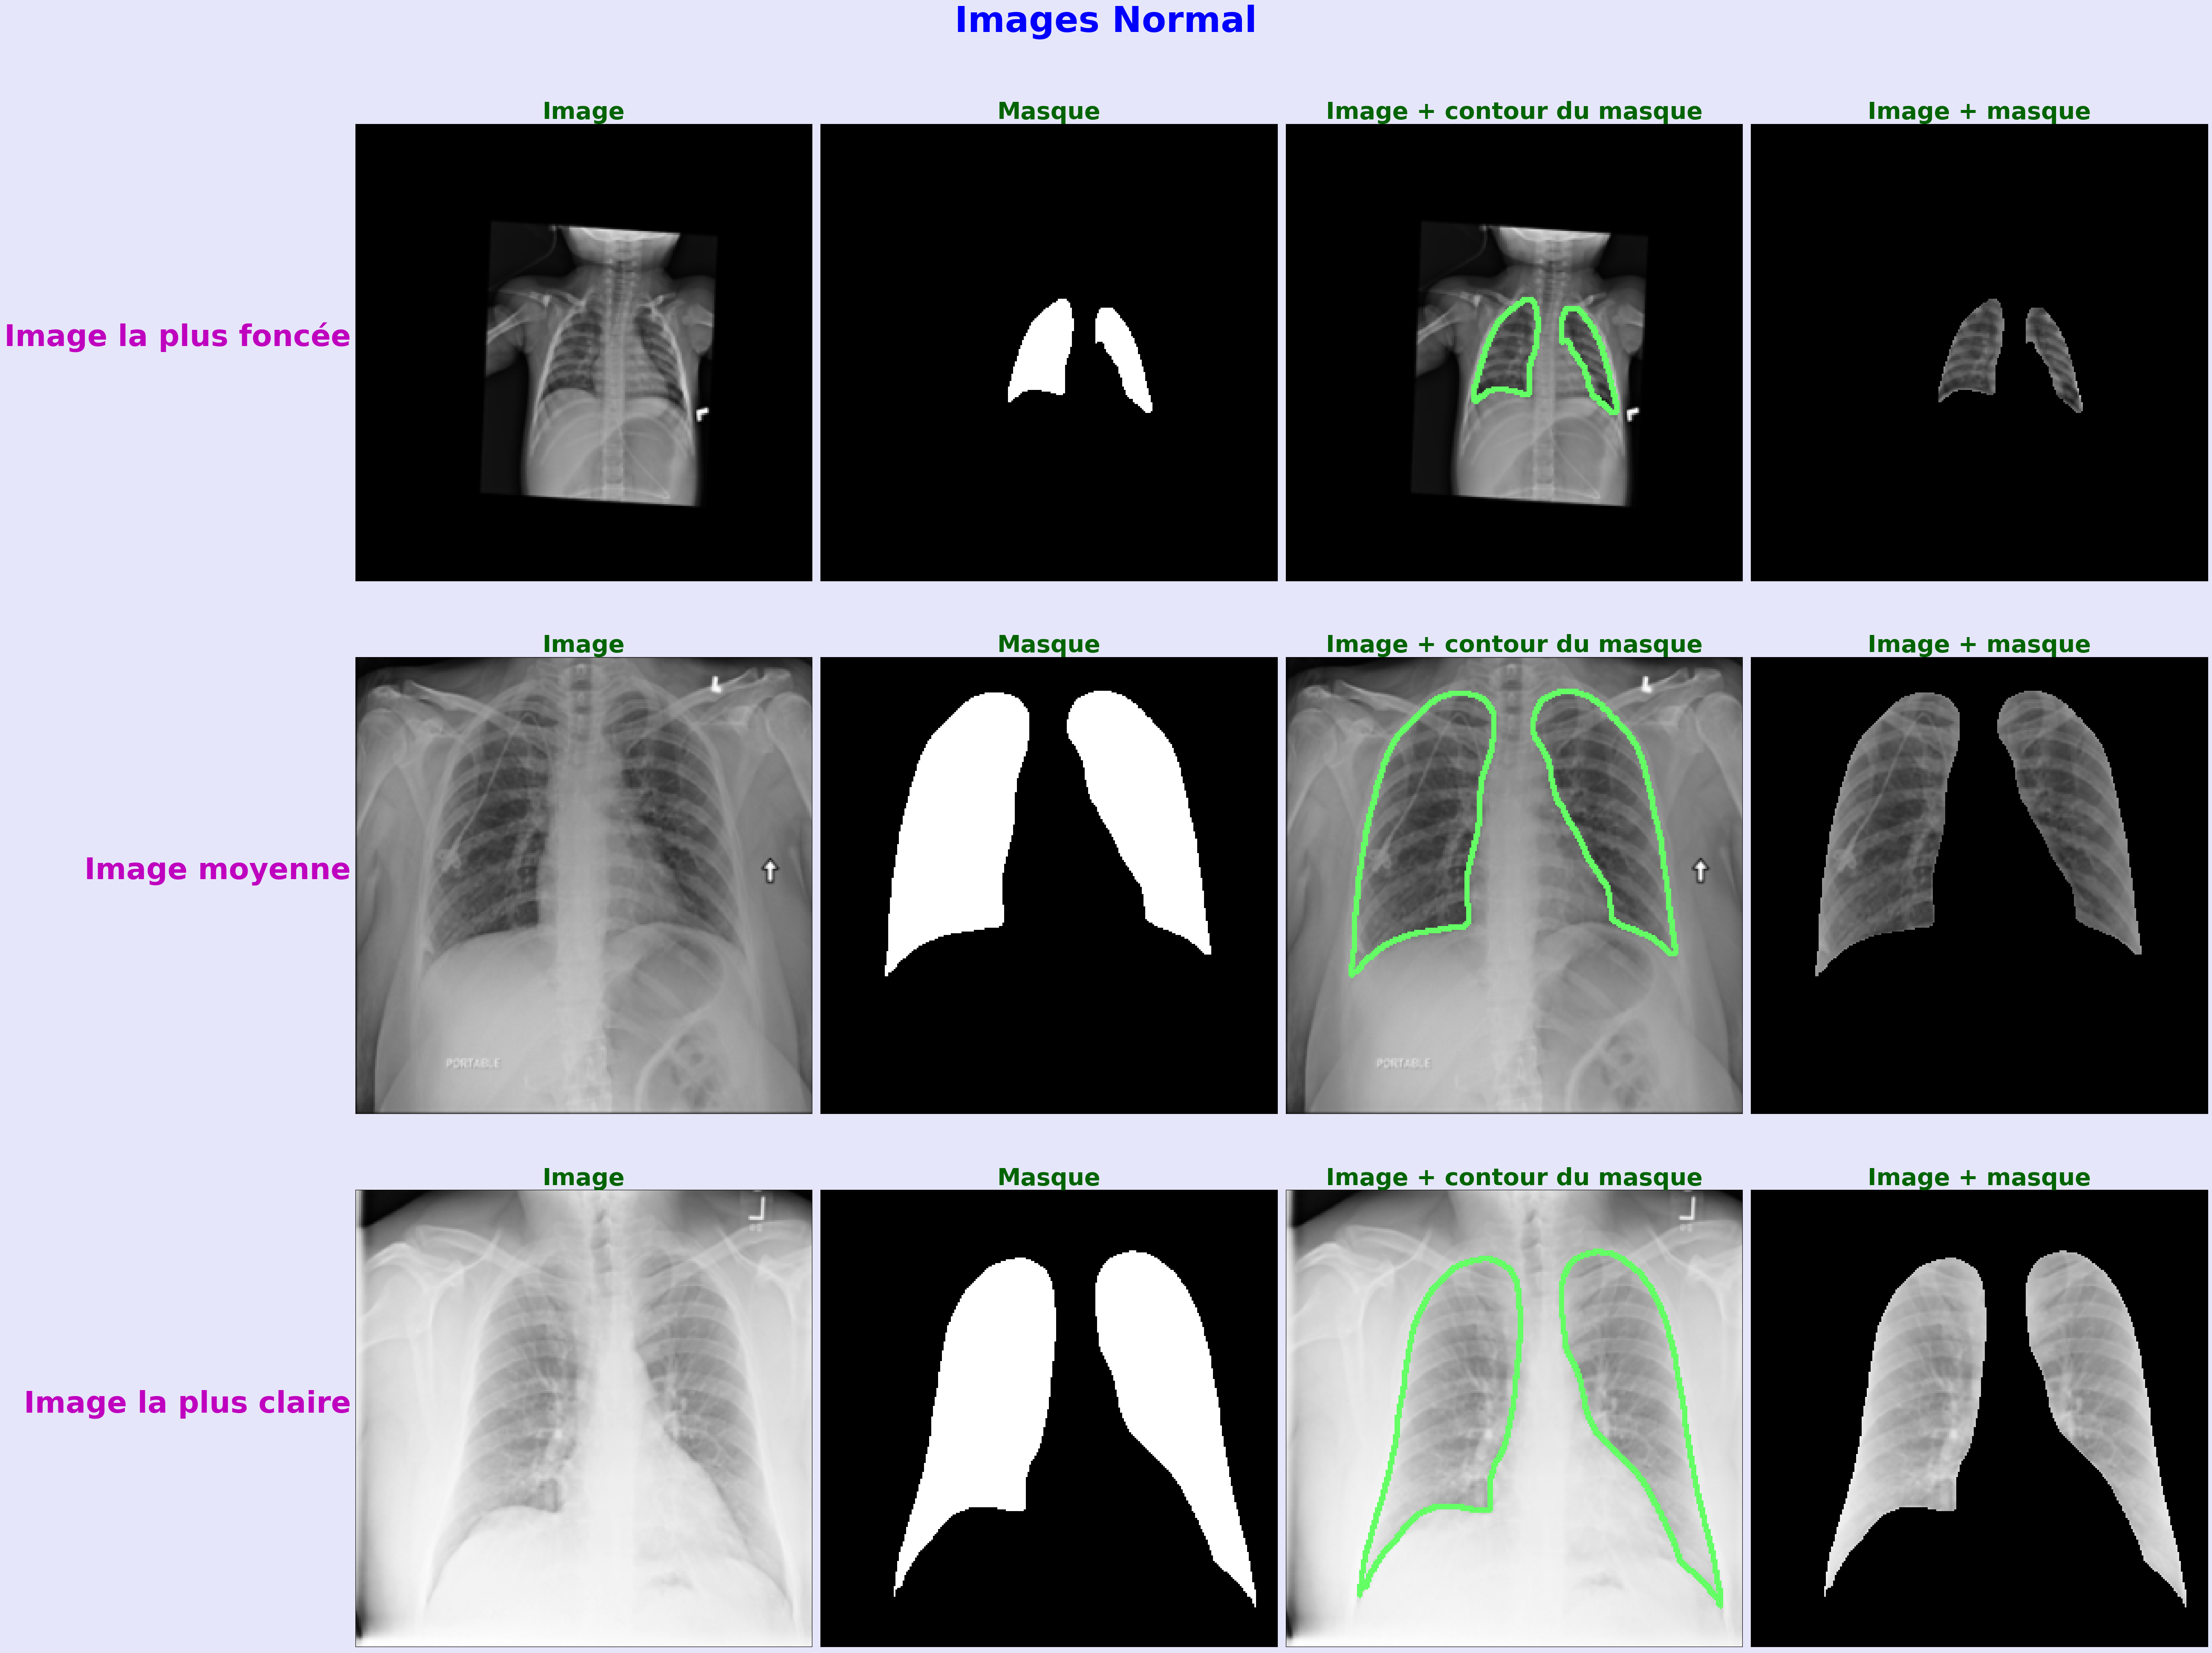

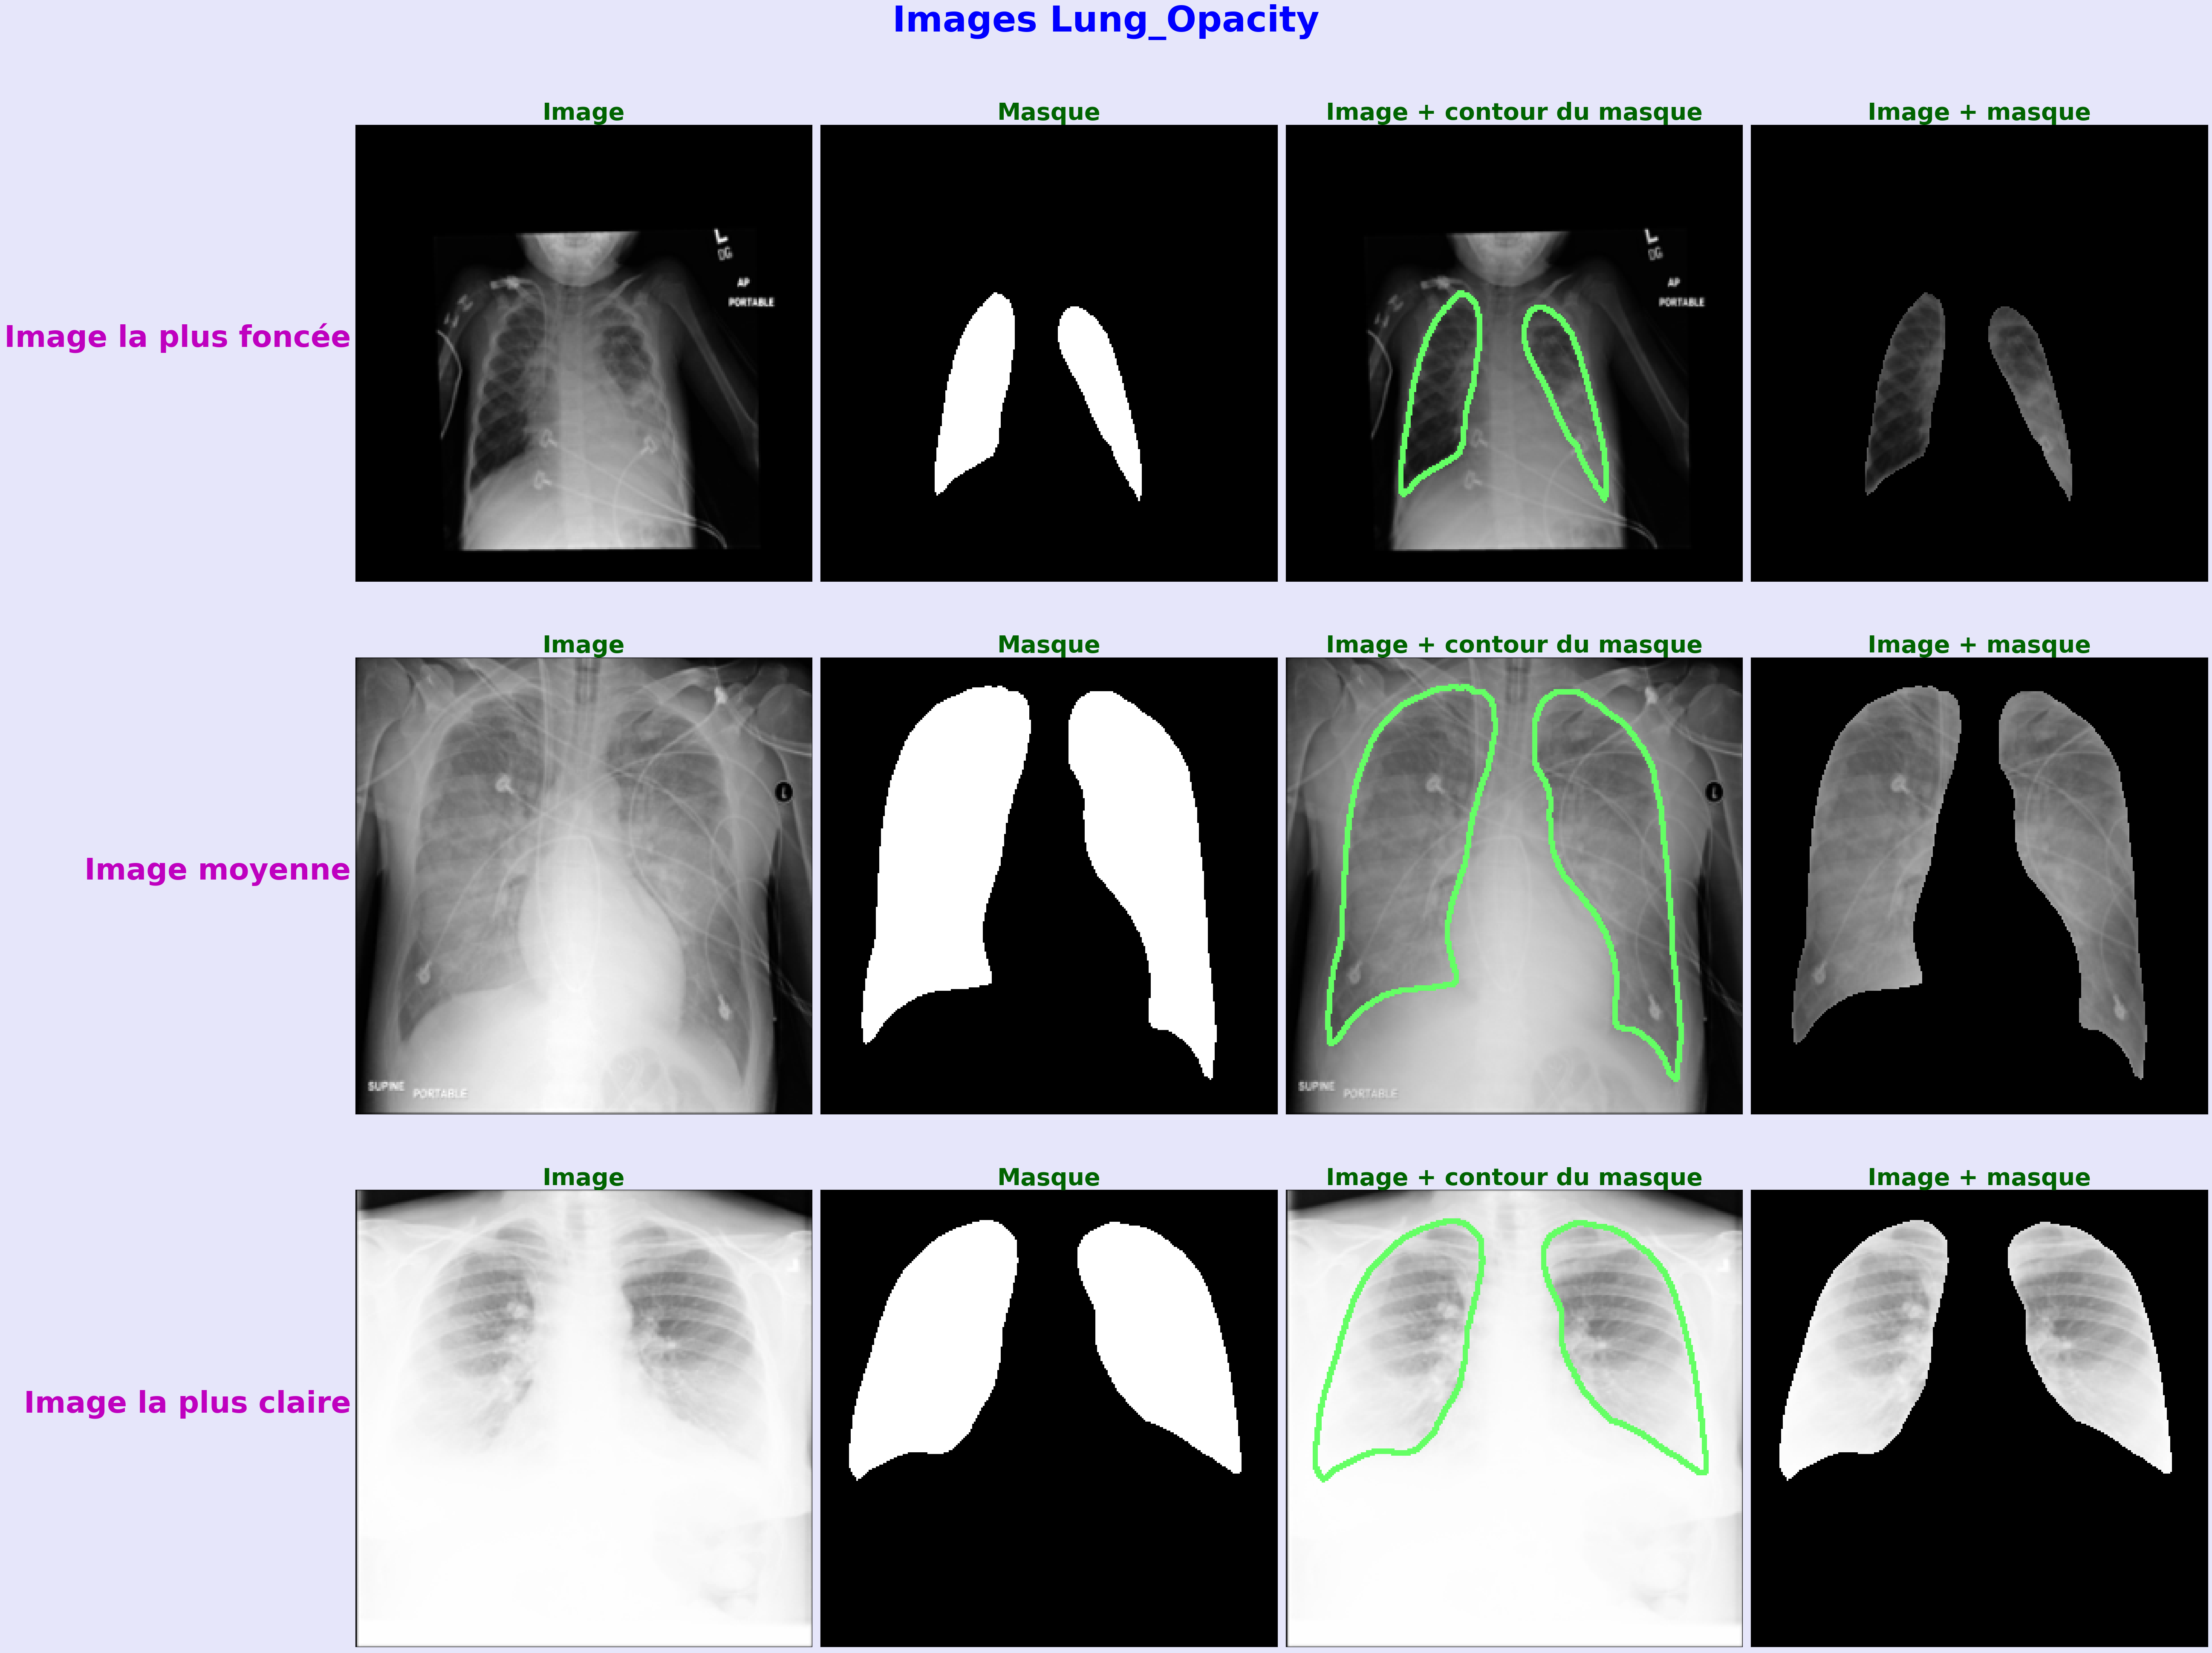

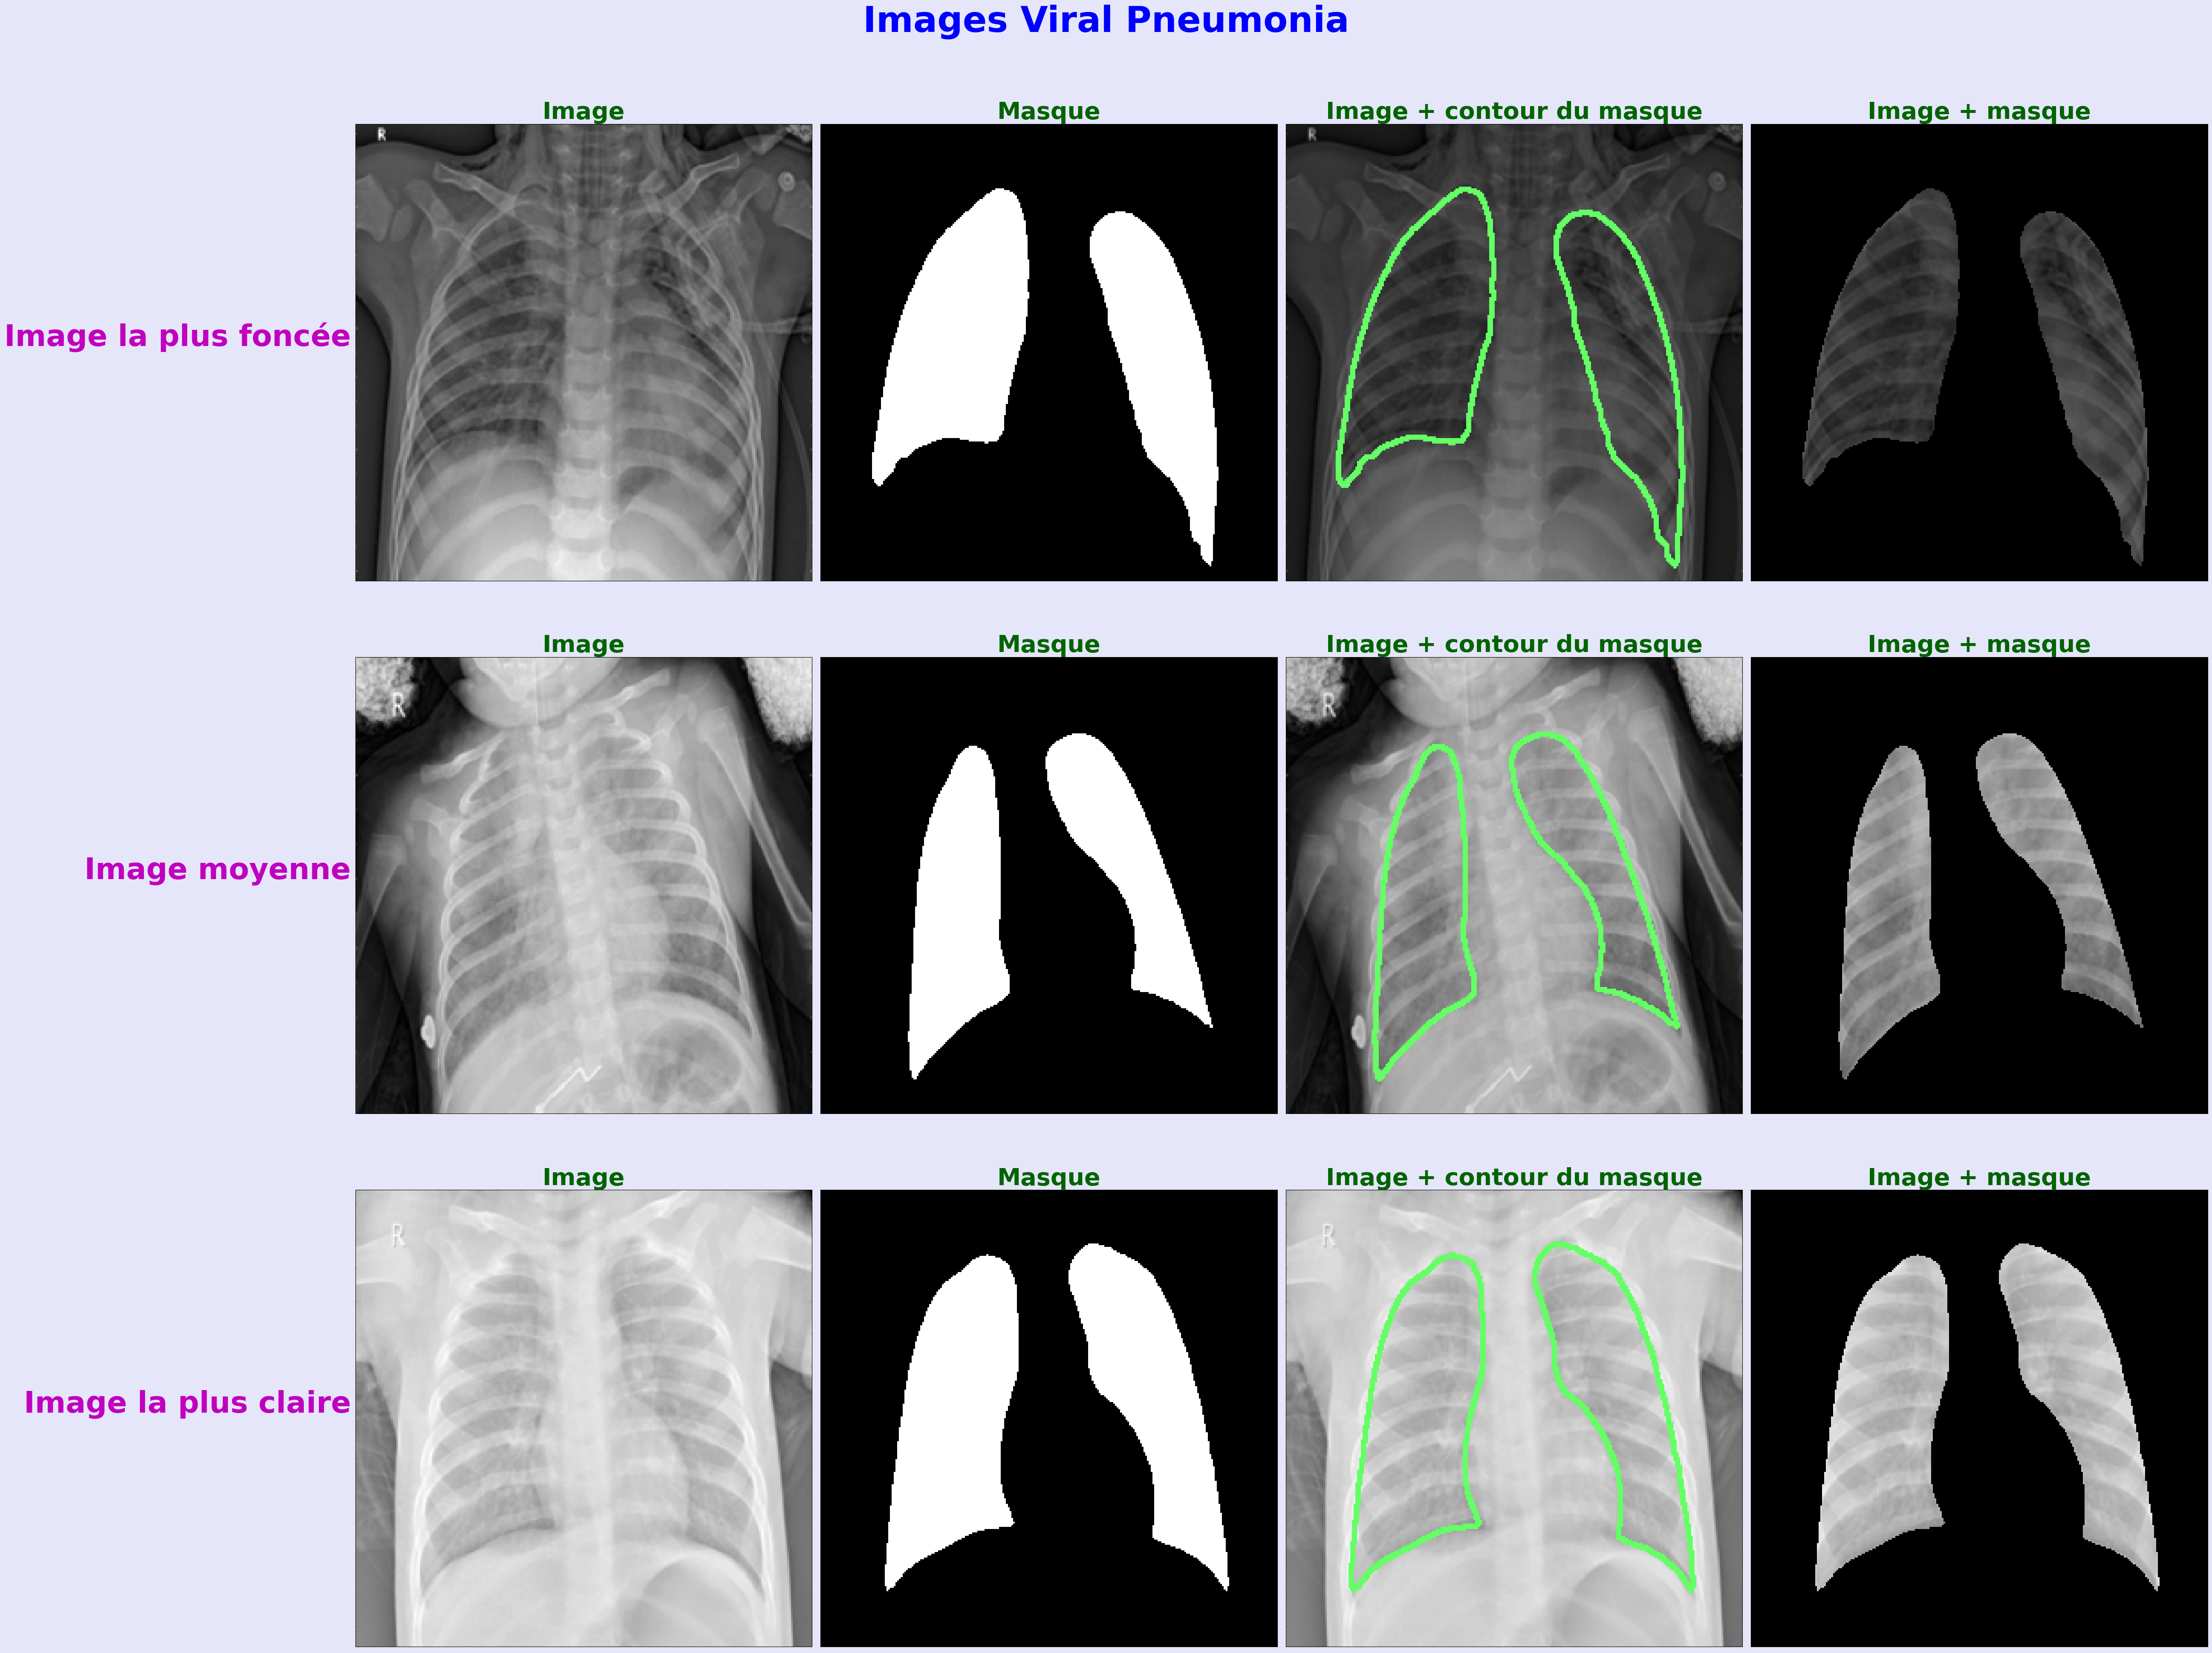

In [16]:
show_images(imgdataset_resize, maskdataset, "images_cm")

<Figure size 4000x1000 with 0 Axes>

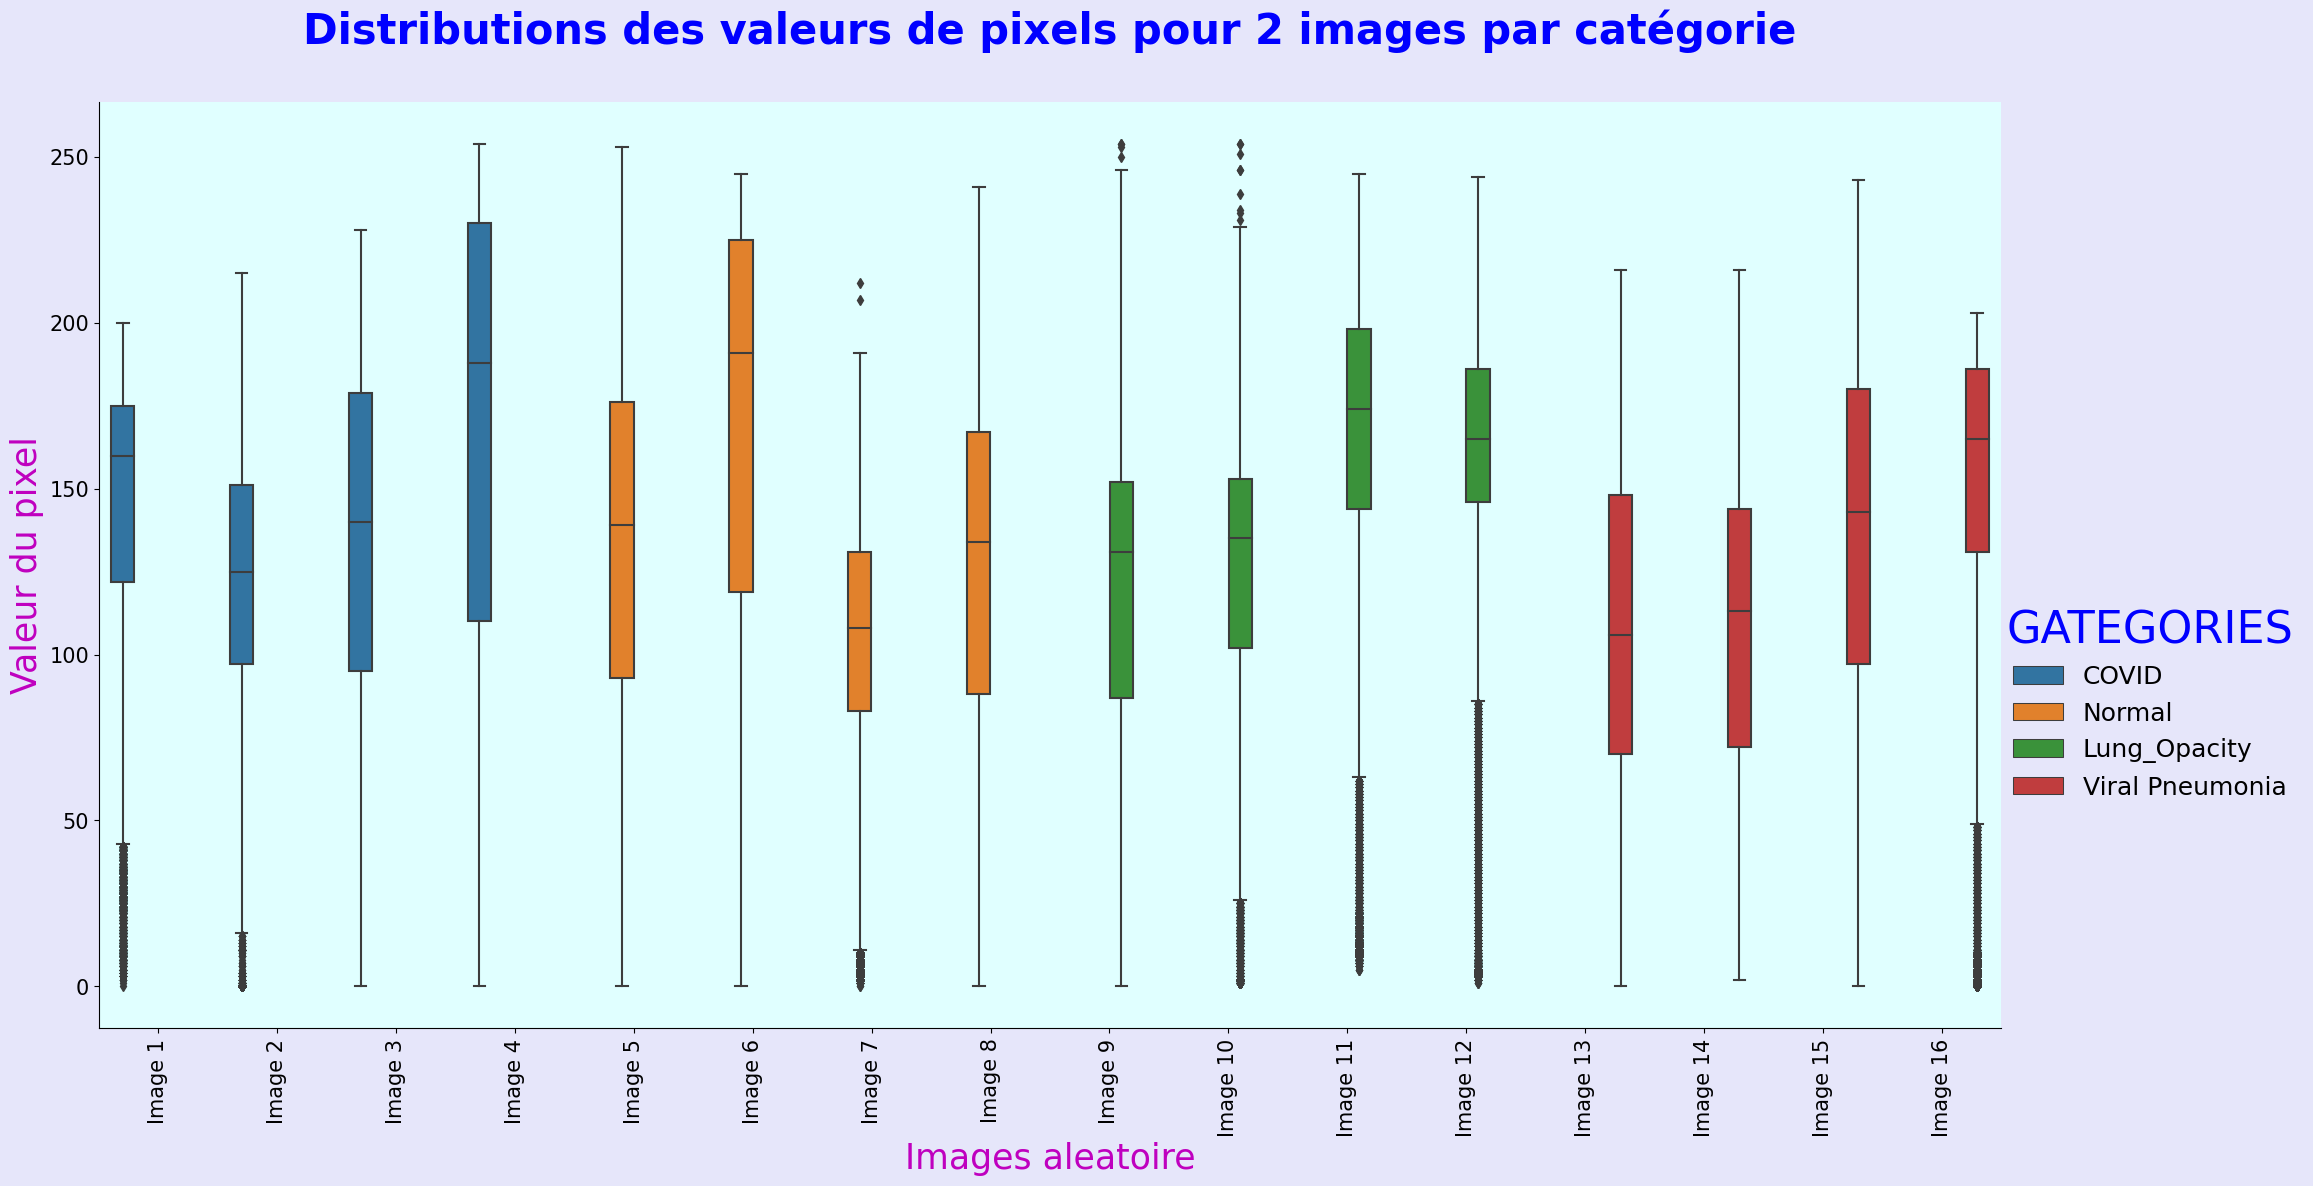

In [17]:
show_dist_pixel(imgdataset_resize, "Distributions des valeurs de pixels pour 2 images par catégorie", "dist_img", 4);

In [18]:
imgdataset_norm = normalize_intensity(imgdataset_resize)

<Figure size 4000x1000 with 0 Axes>

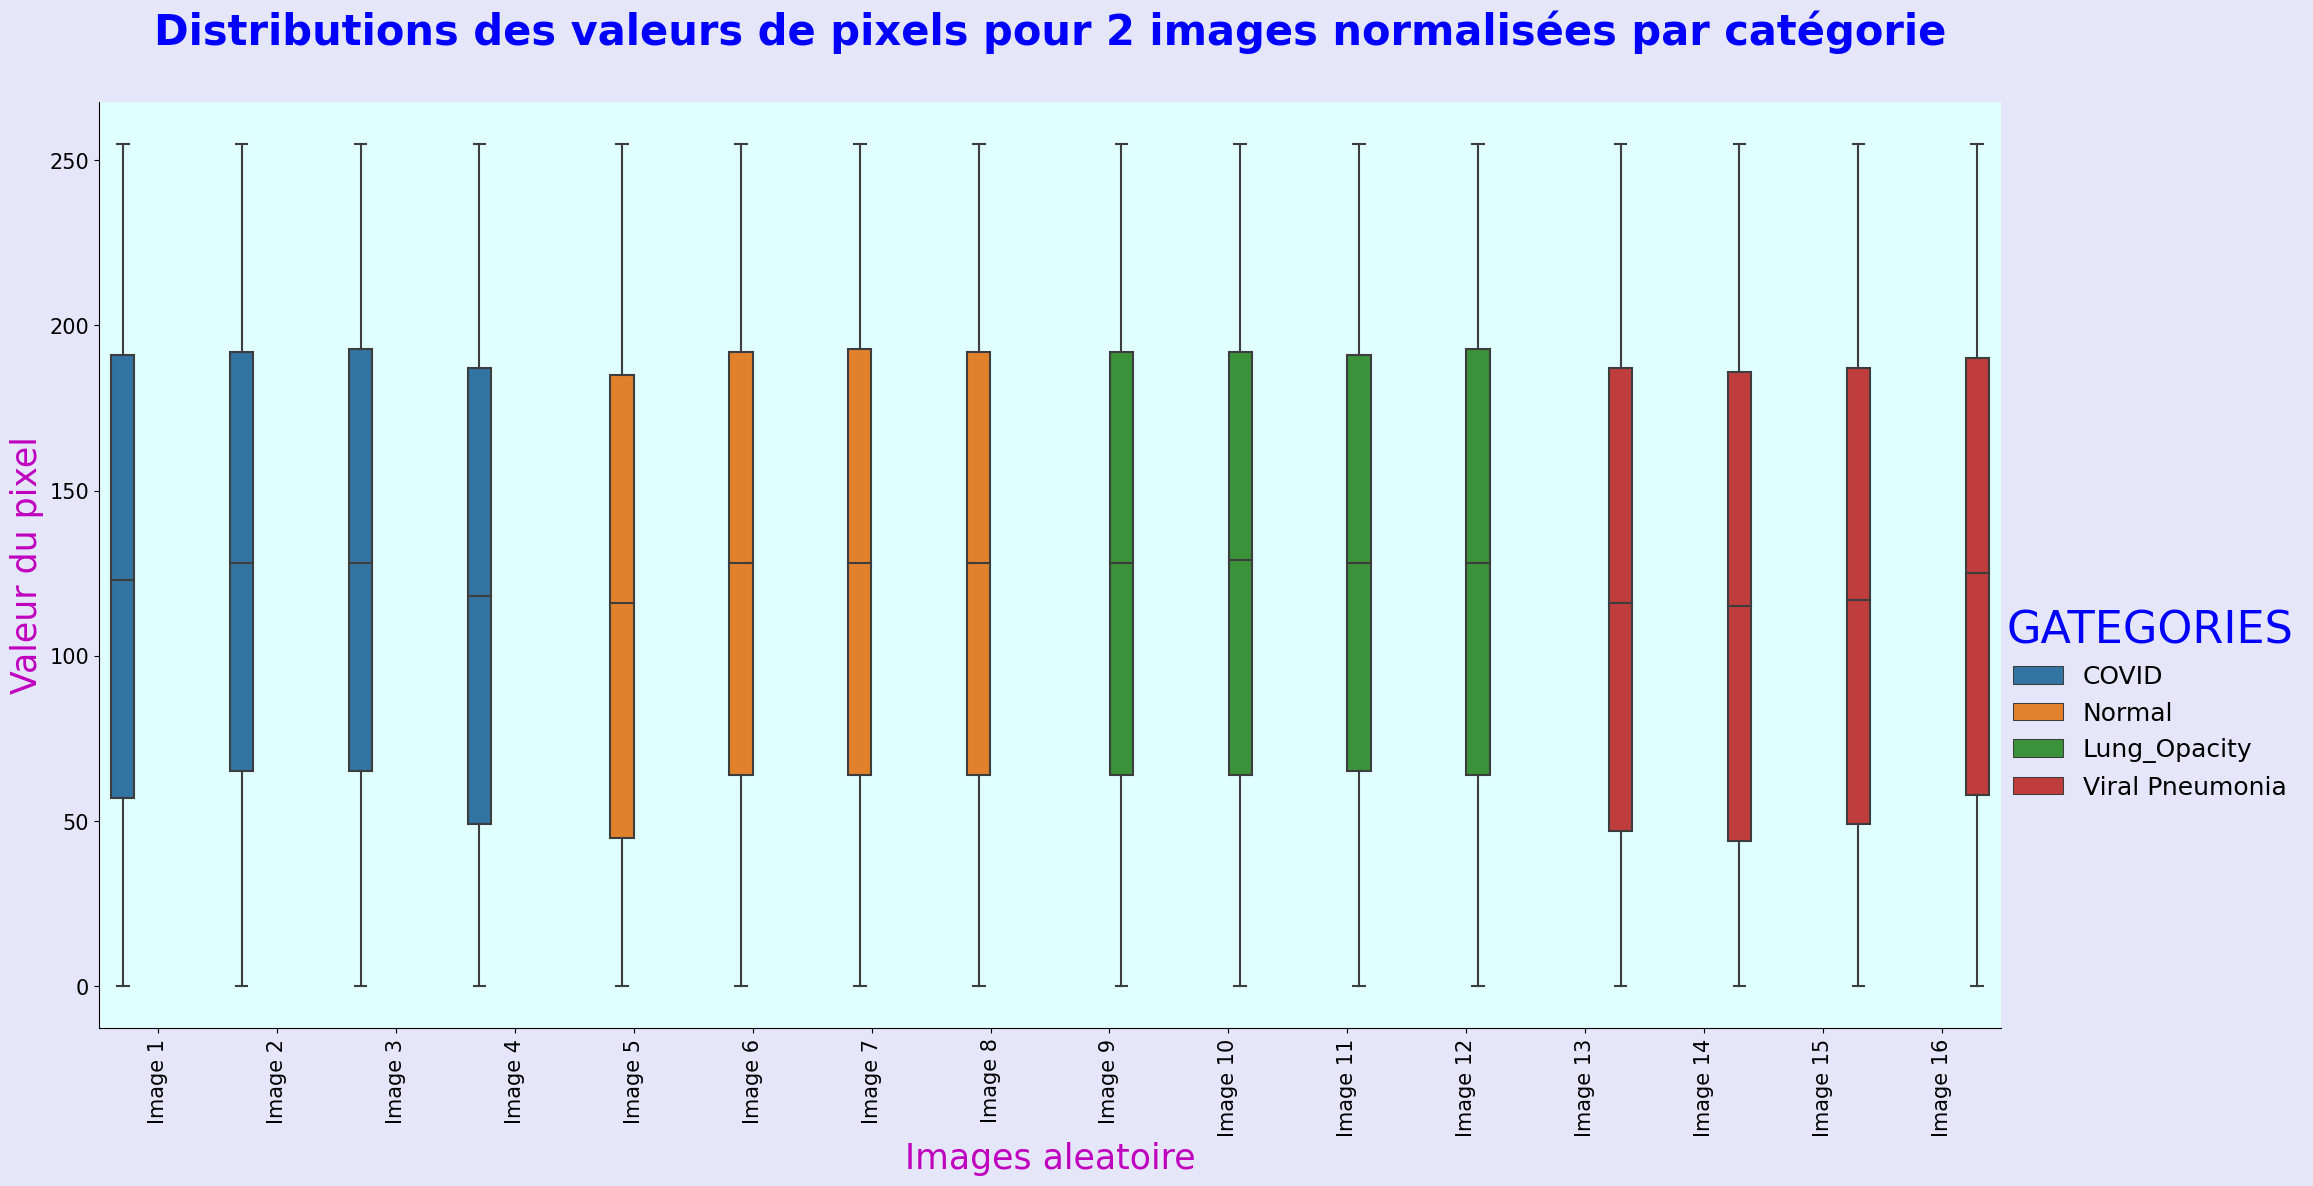

In [19]:
show_dist_pixel(imgdataset_norm, "Distributions des valeurs de pixels pour 2 images normalisées par catégorie", "dist_img_norm", 4)

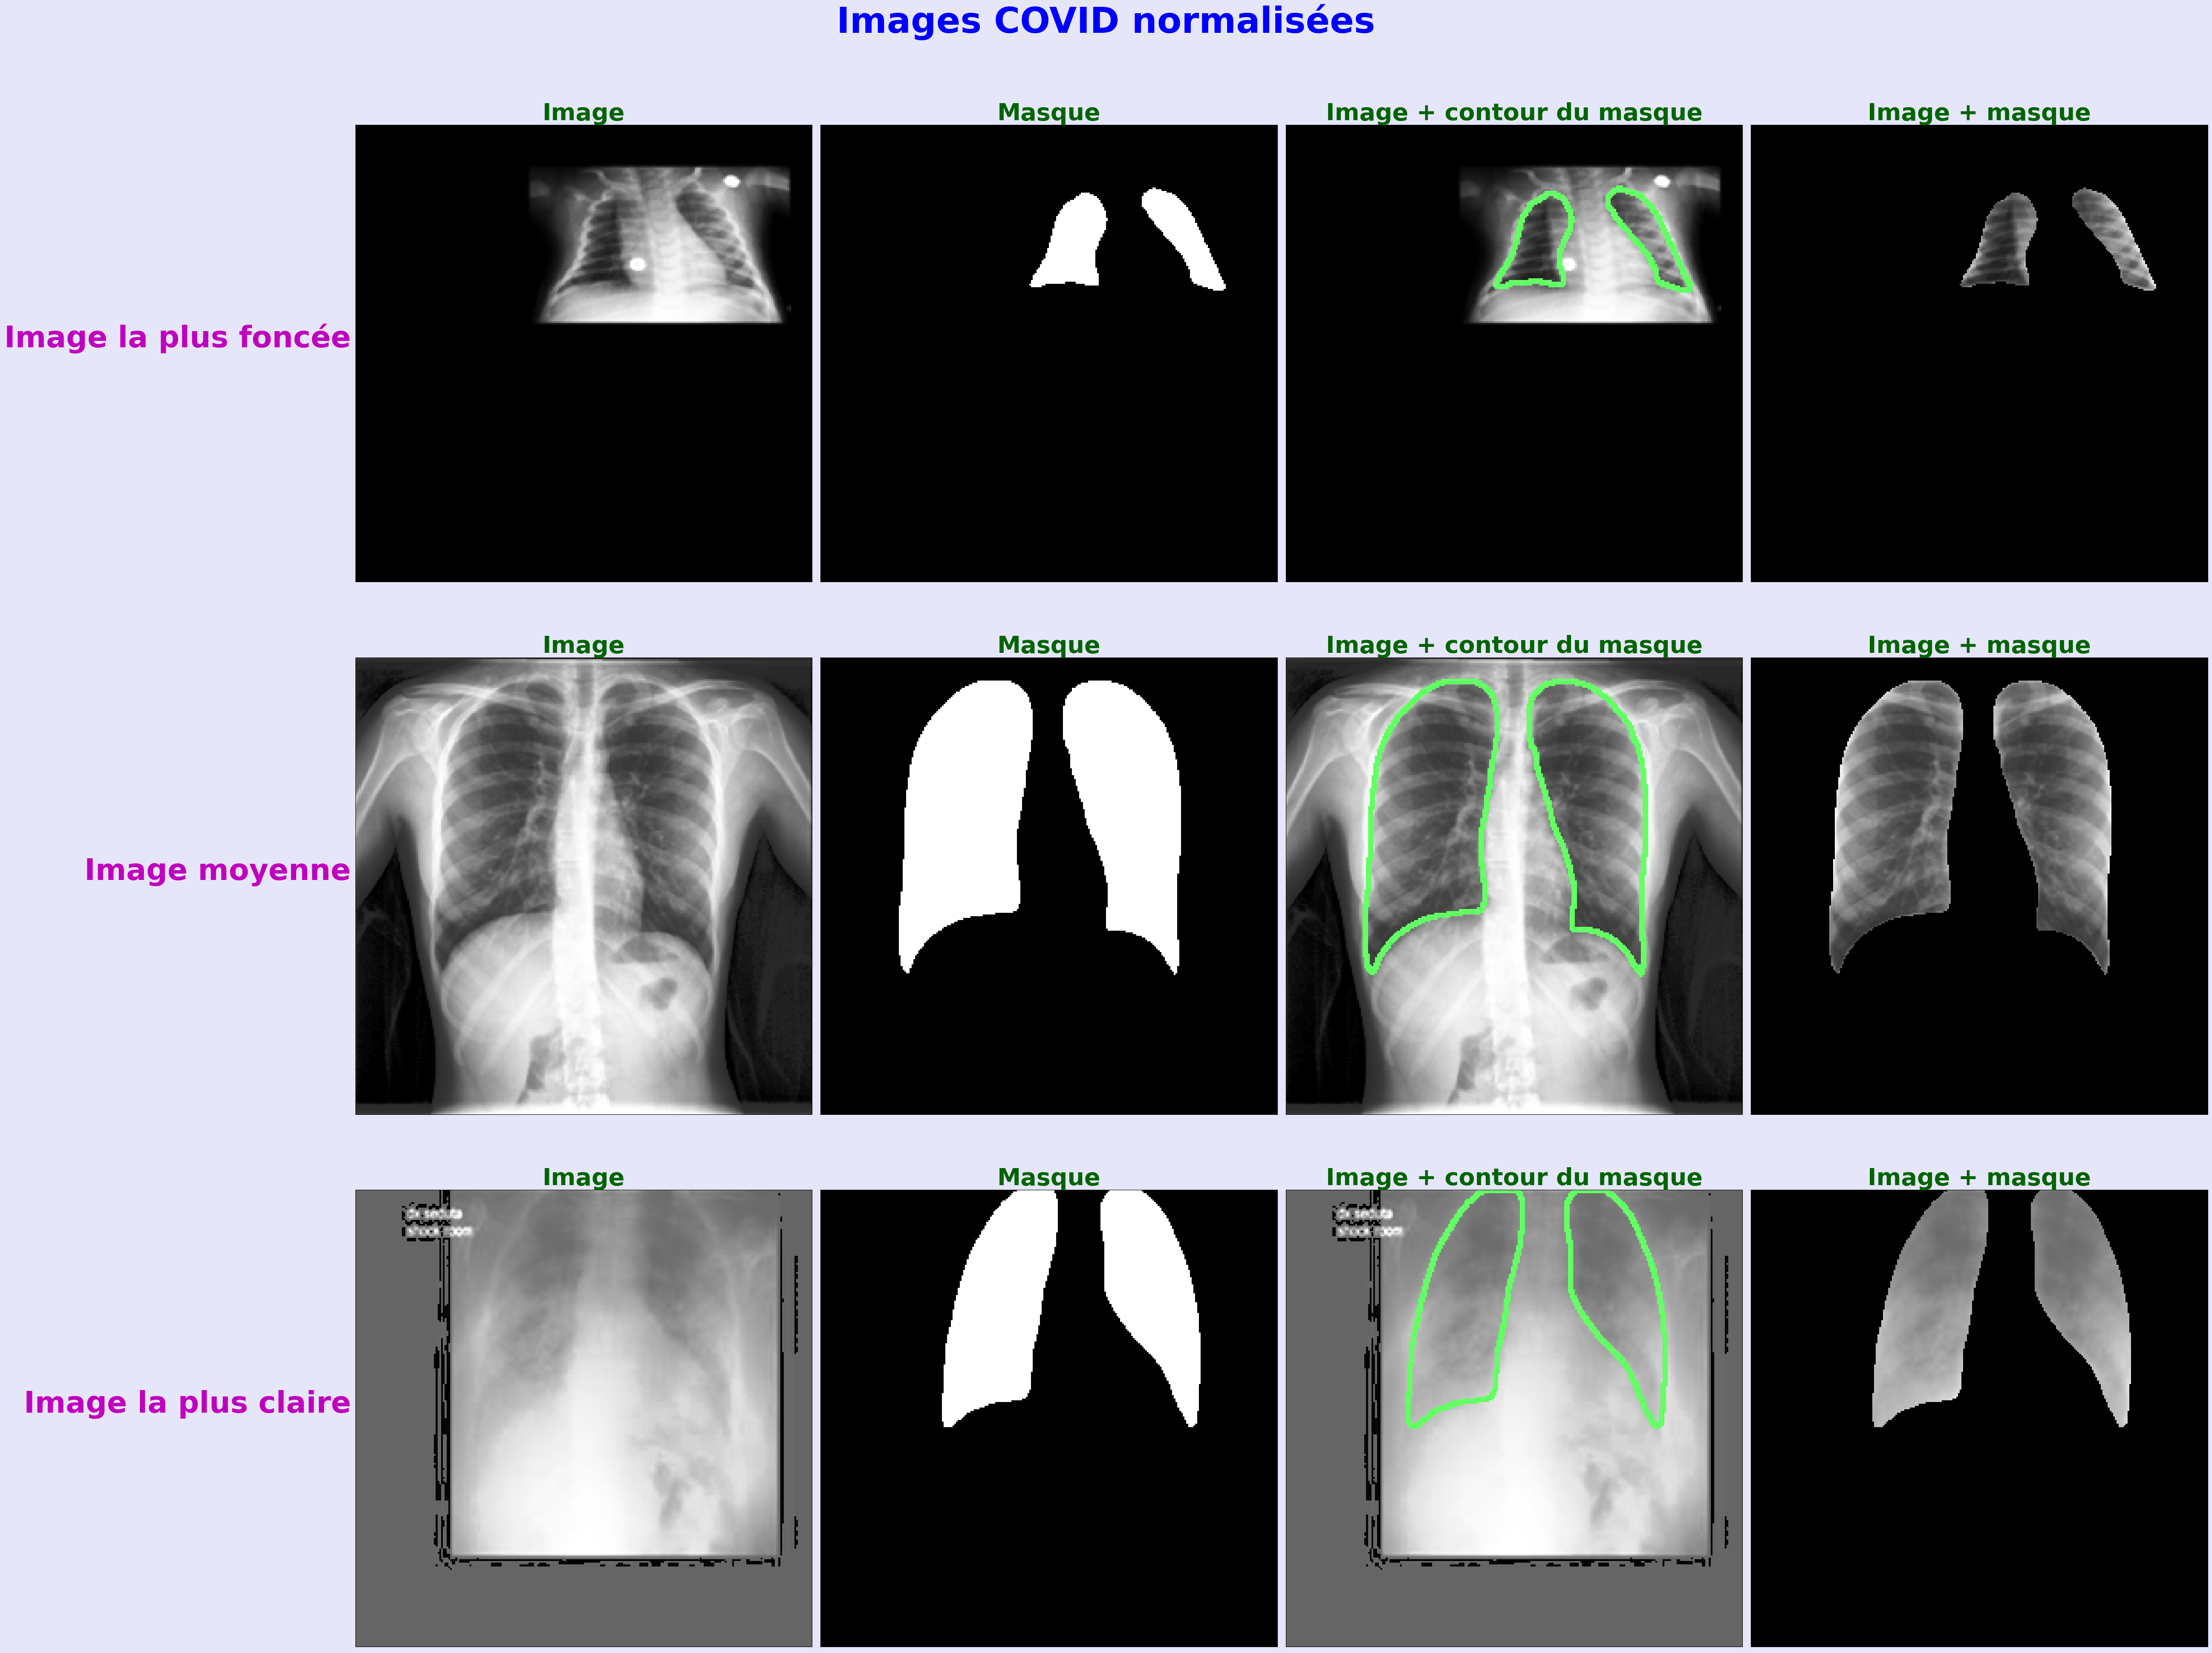

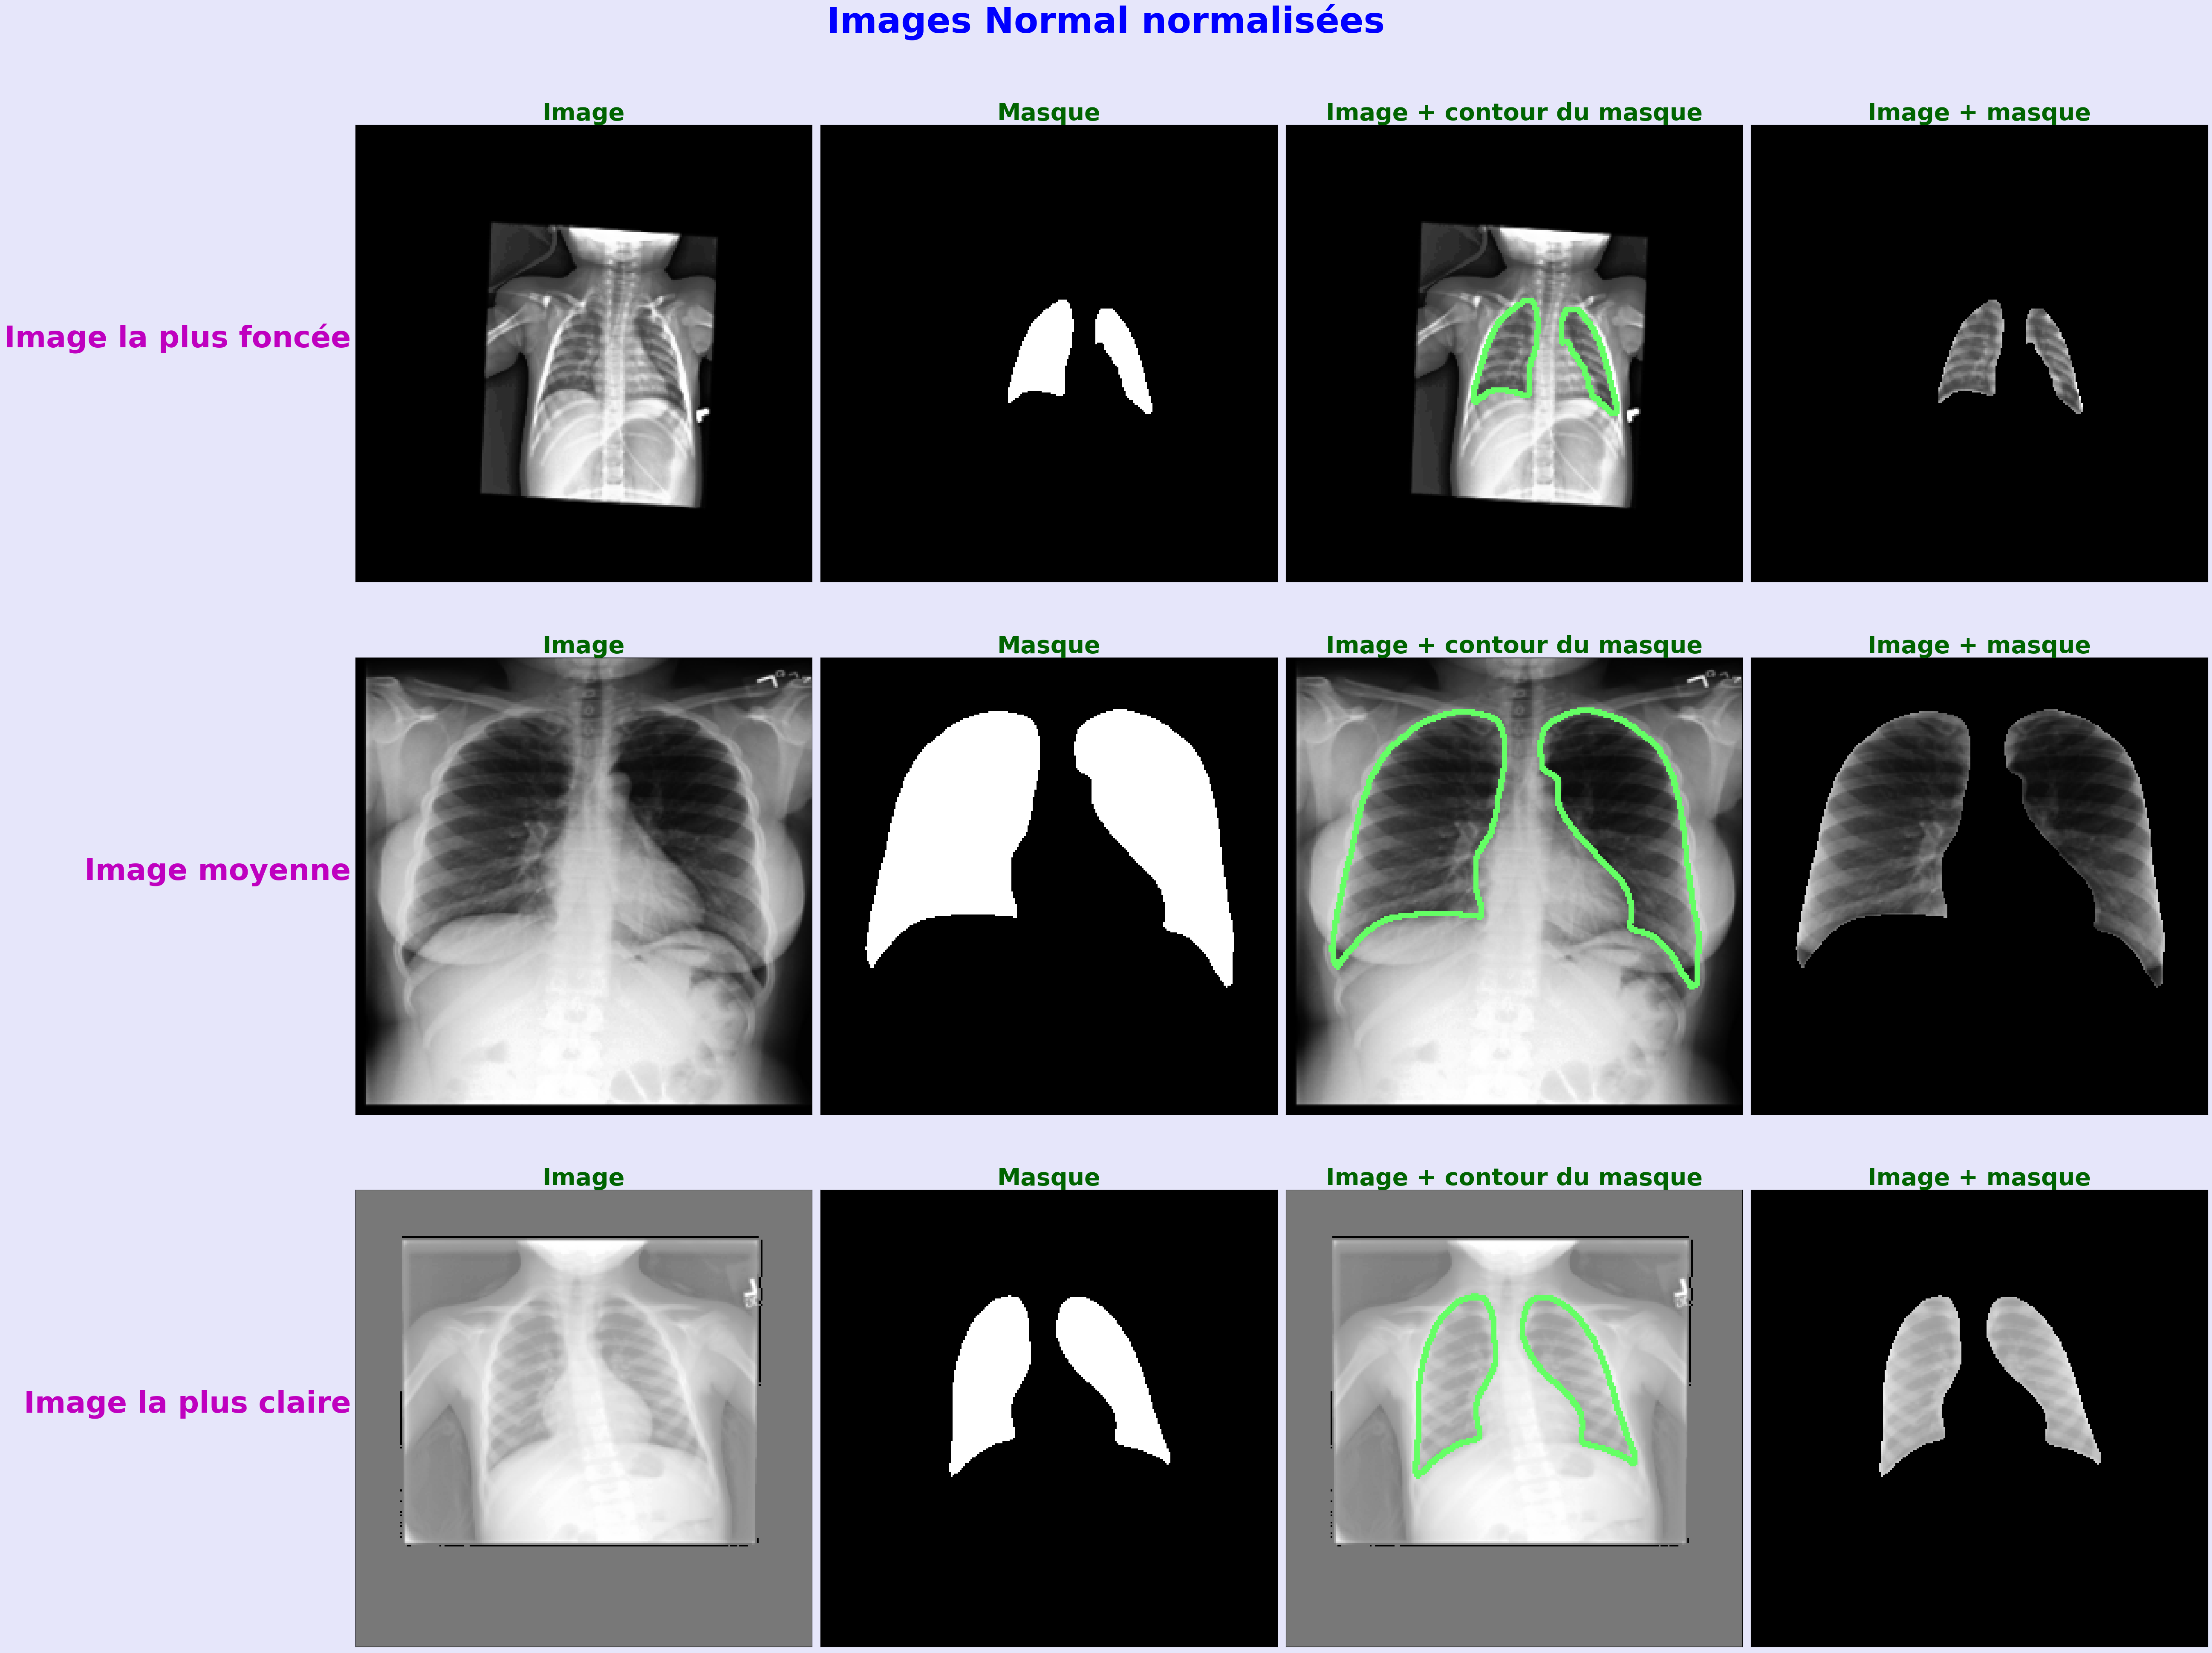

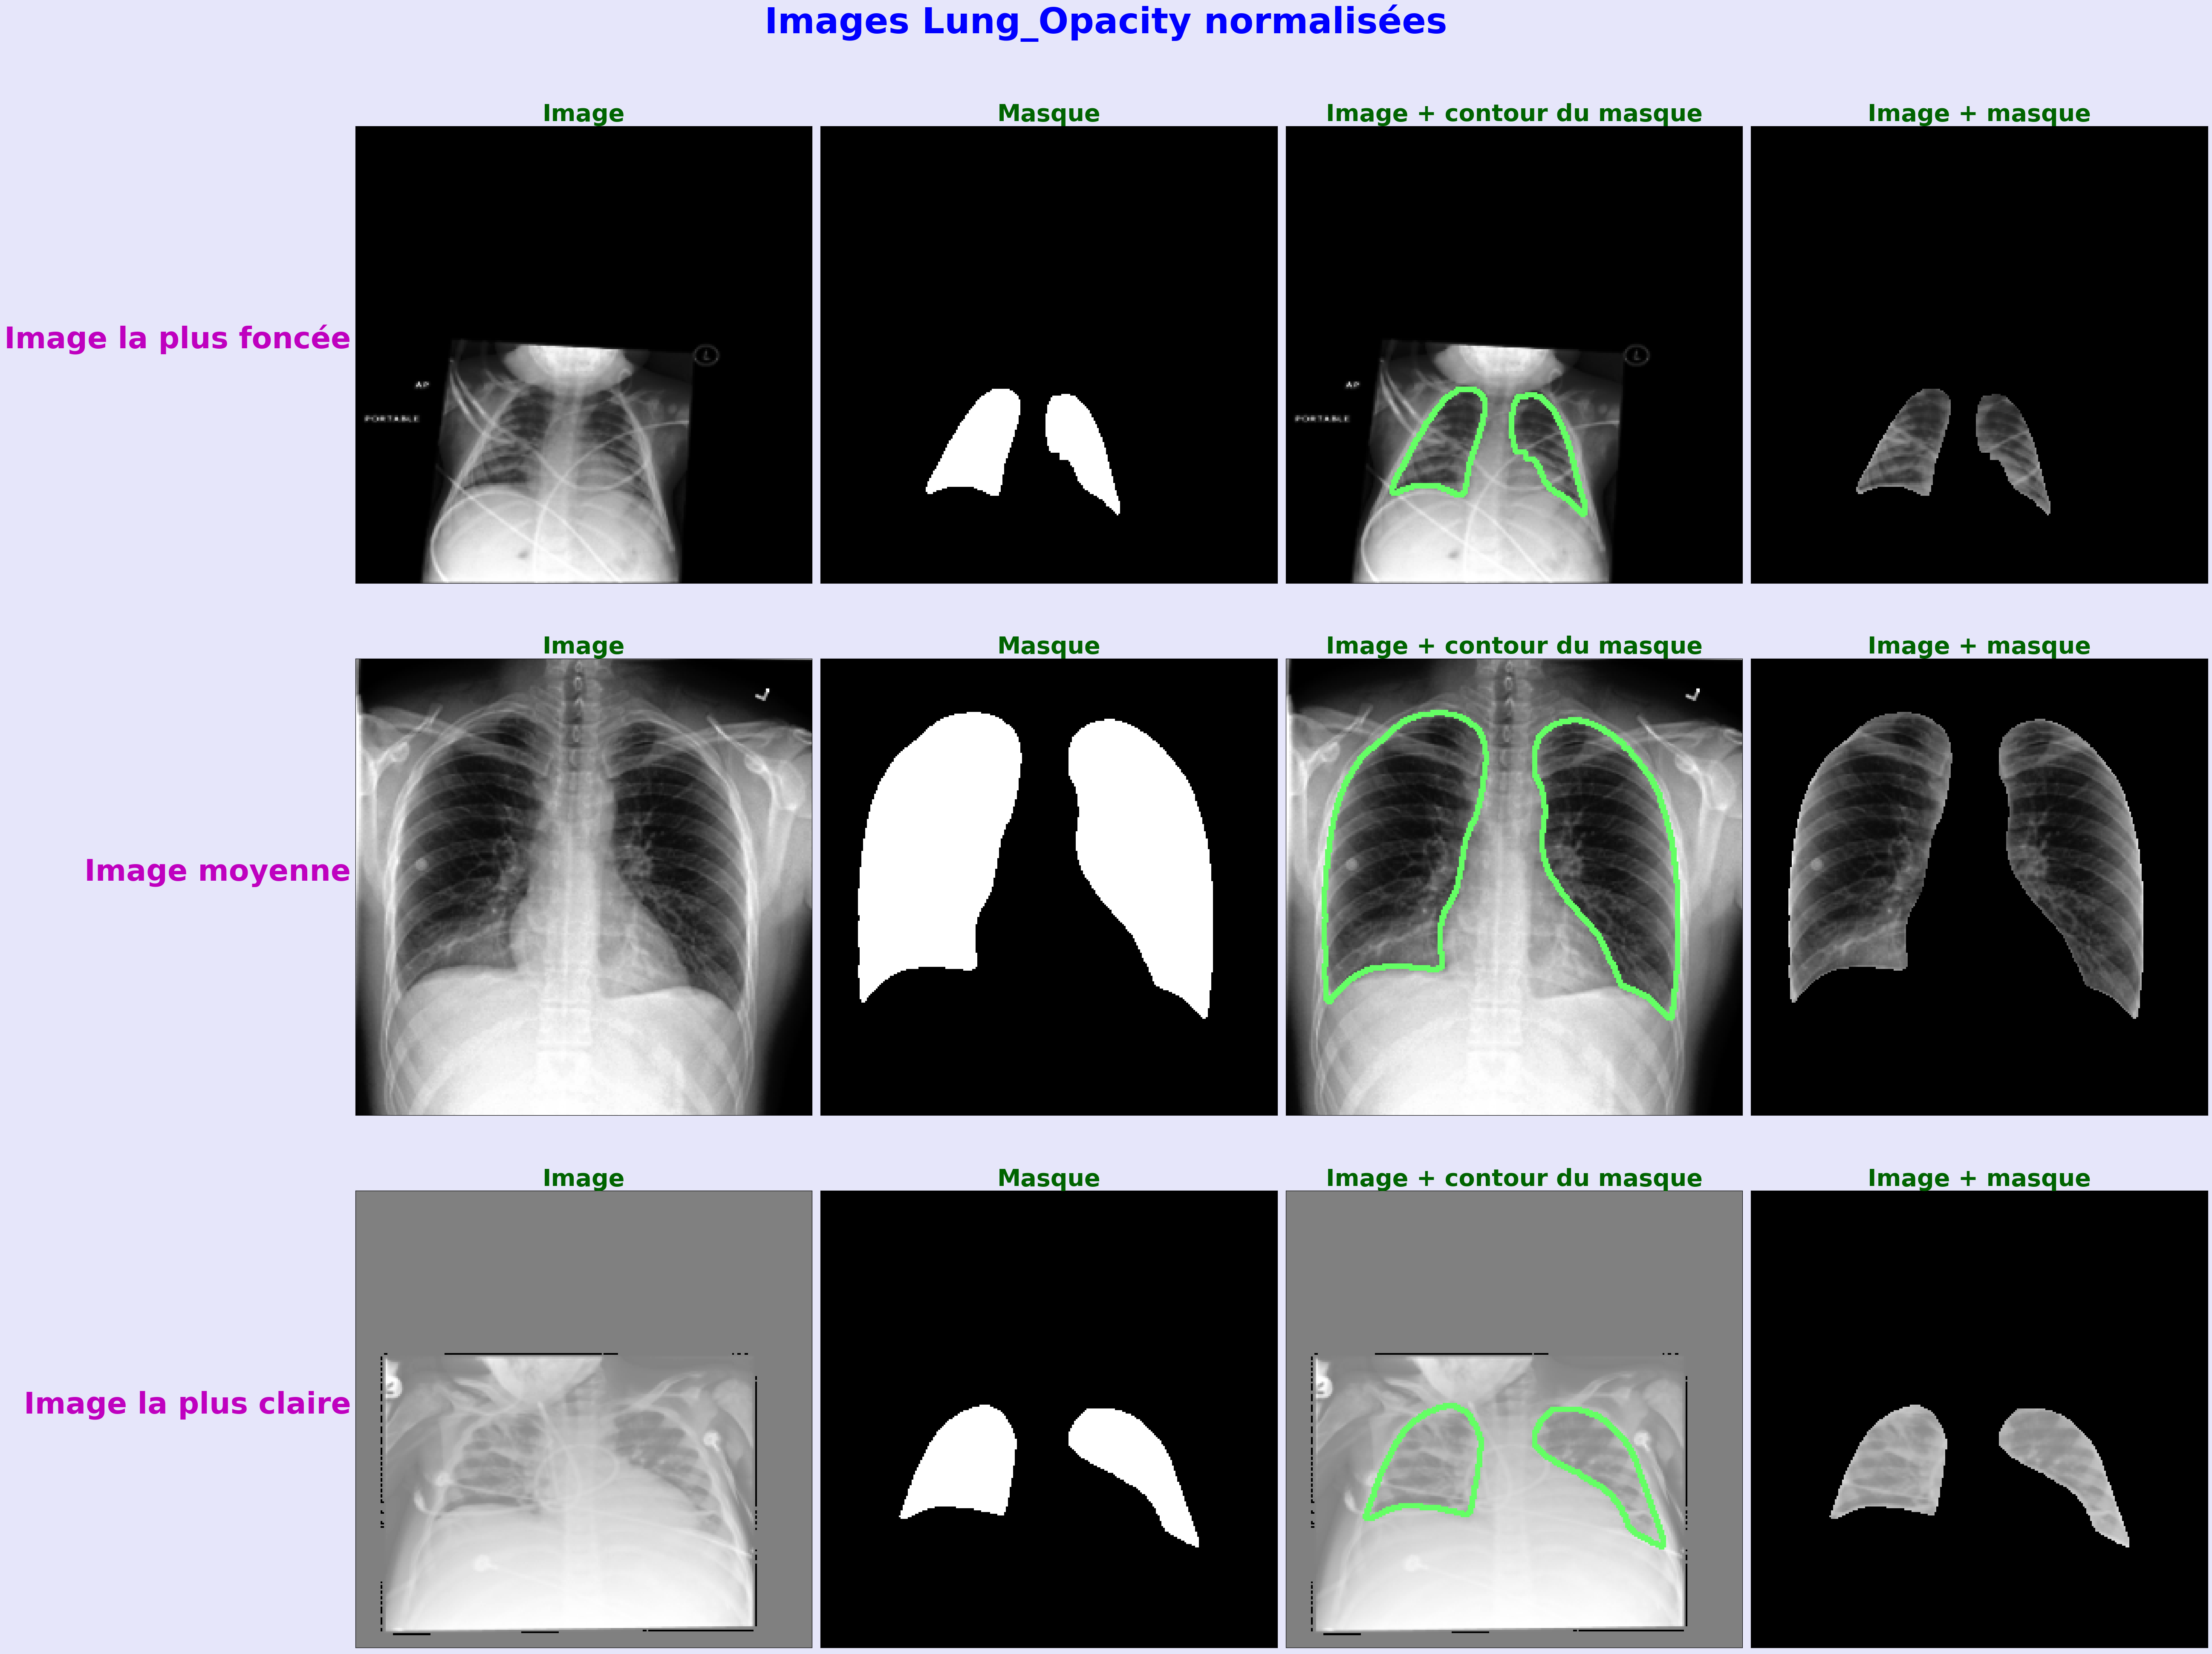

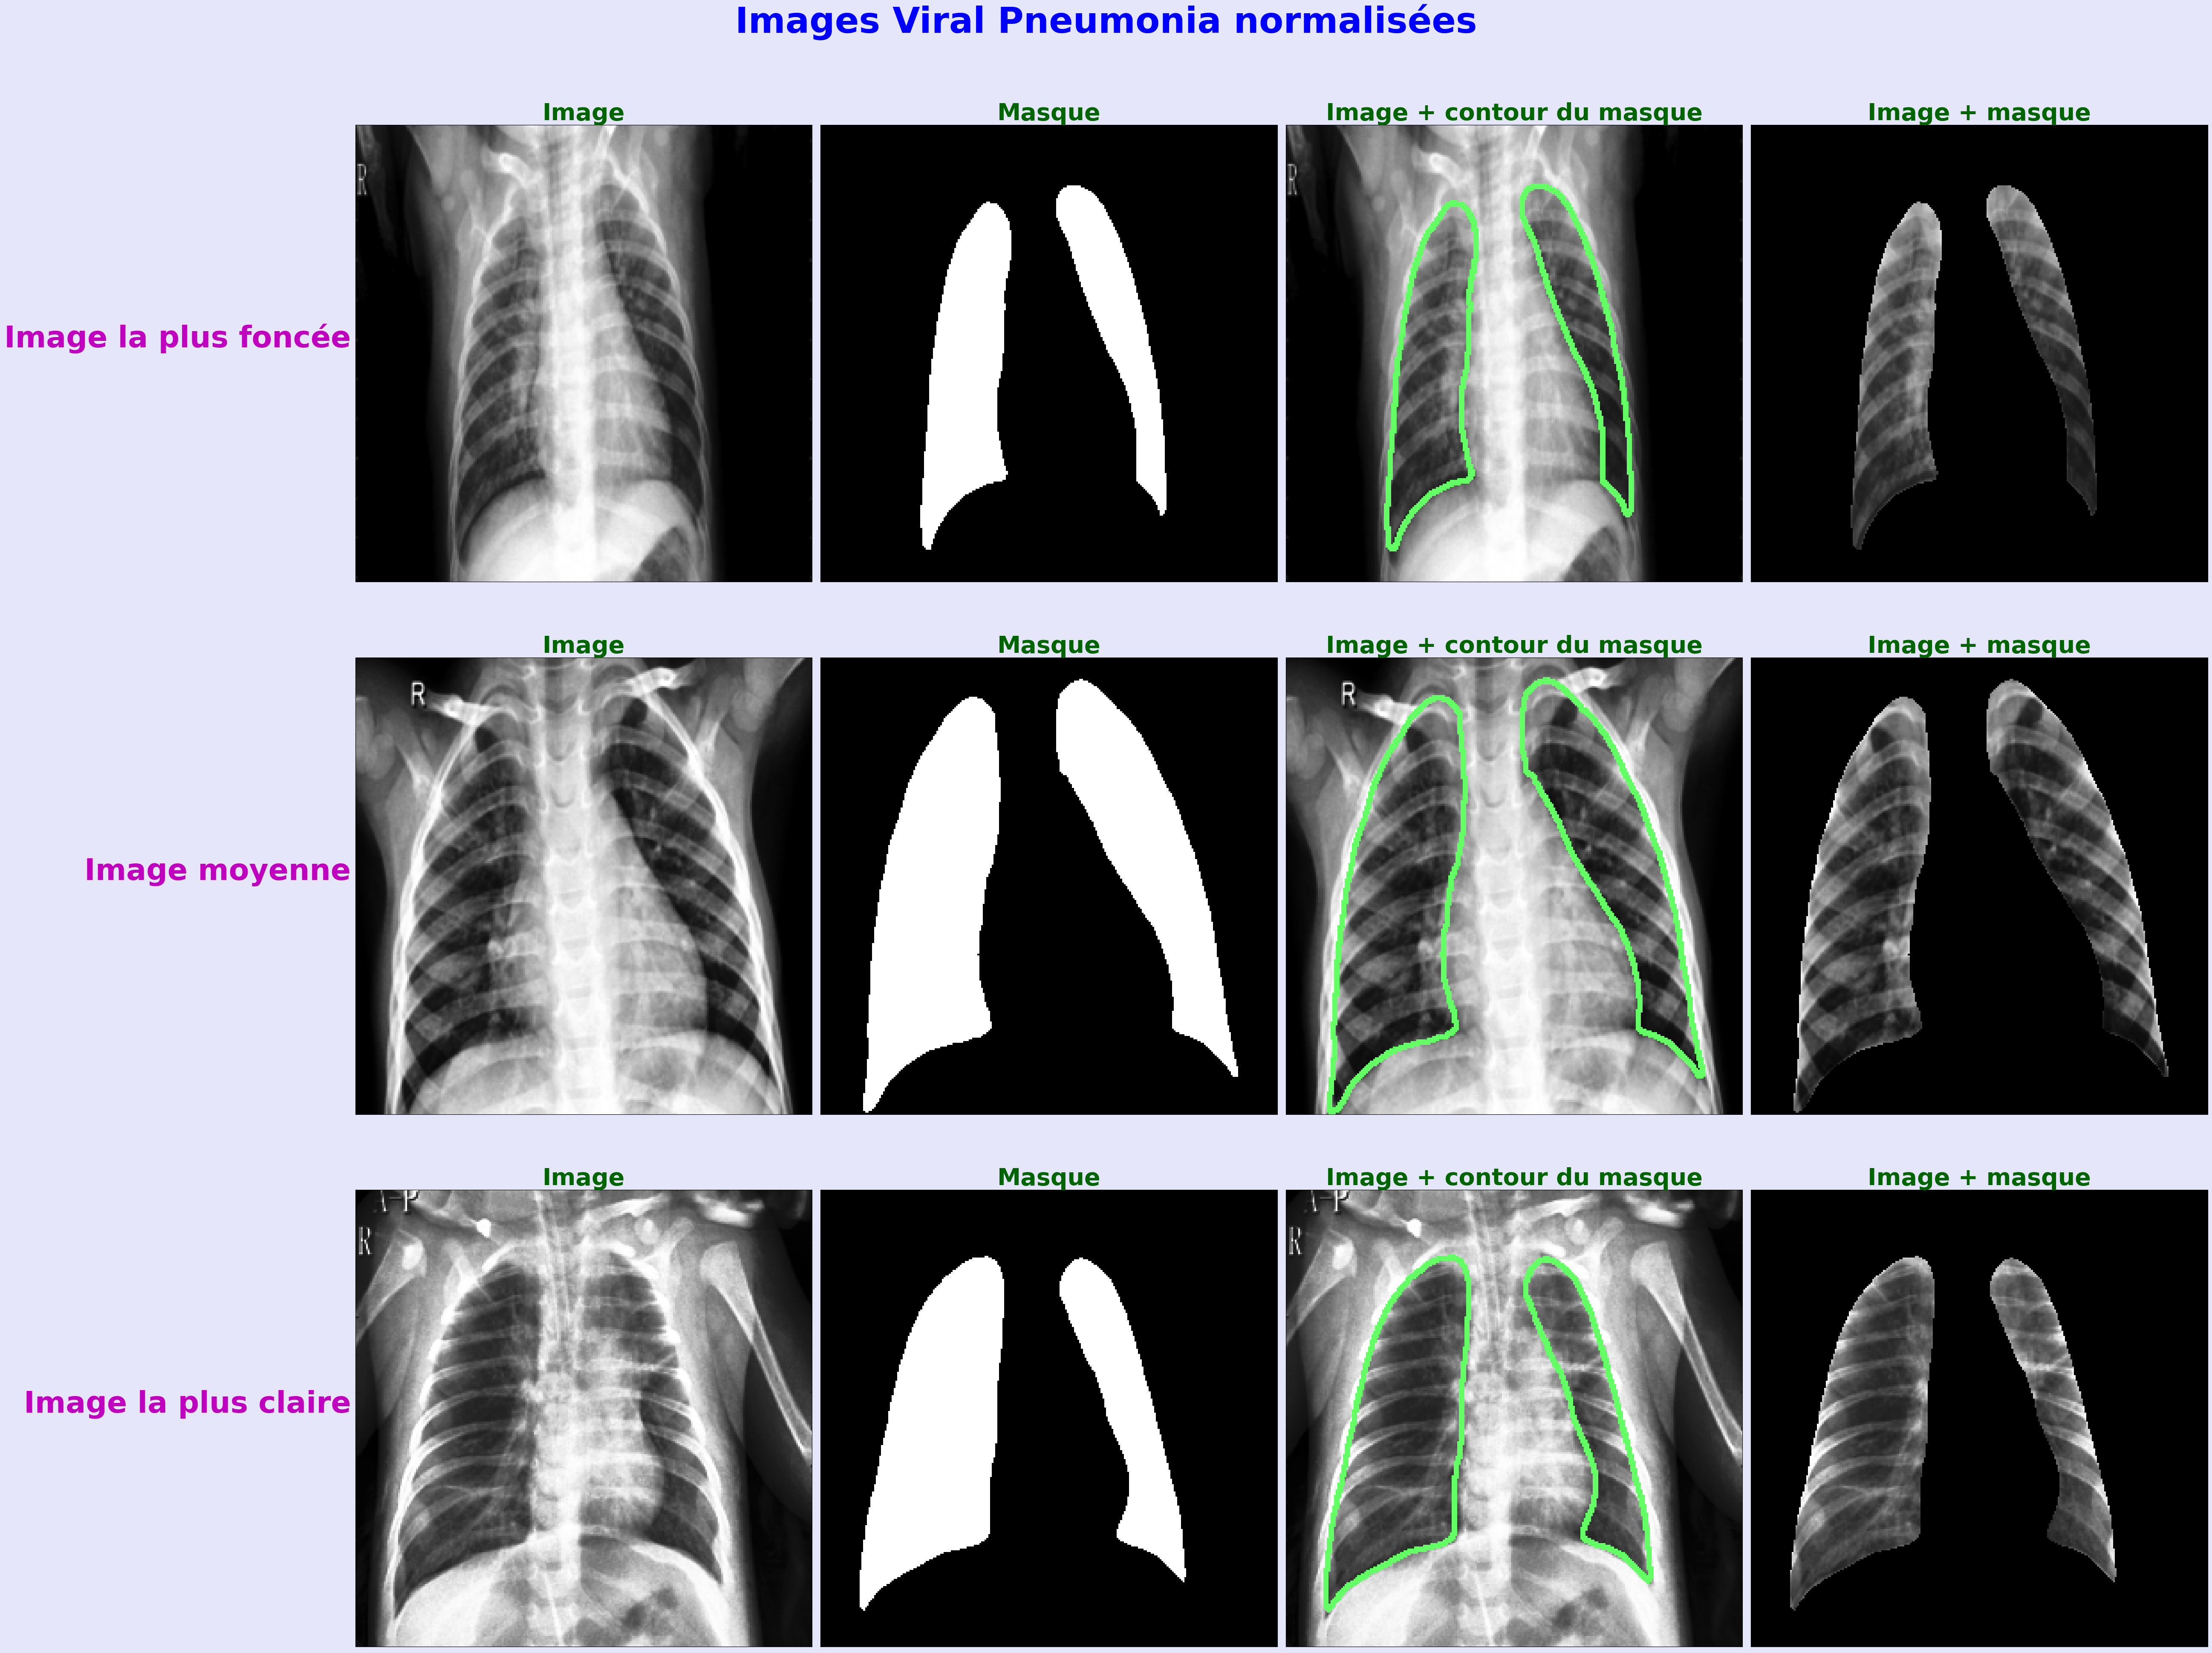

In [20]:
show_images(imgdataset_norm, maskdataset, "images_ncm", True)

La cellule de code ci-dessus effectue un processus similaire à la fonction décrite précédemment. Elle prend en entrée un ensemble de données d'images normalisées et un ensemble de données de masques correspondants. Pour chaque image dans l'ensemble de données normalisées, elle utilise la fonction cv2.bitwise_and() de OpenCV pour superposer le masque correspondant à l'image en utilisant l'opération logique ET bit à bit. L'opération logique ET bit à bit ne conserve que les pixels qui sont à 1 dans les deux images d'entrée. Cela permet de masquer les parties de l'image qui ne sont pas pertinentes pour l'analyse. La cellule stocke ensuite les images masquées dans une liste img_masked et retourne cette liste.

In [21]:
# Liste pour stocker les images masquées
img_masked = []

# Boucle sur toutes les images normalisées dans le jeu de données
for i in range(len(imgdataset_norm)):
    image = imgdataset_norm[i]
    # Application du masque à l'image en utilisant l'opération ET bit à bit
    img_masked.append(cv2.bitwise_and(image, image, mask=maskdataset[i]))

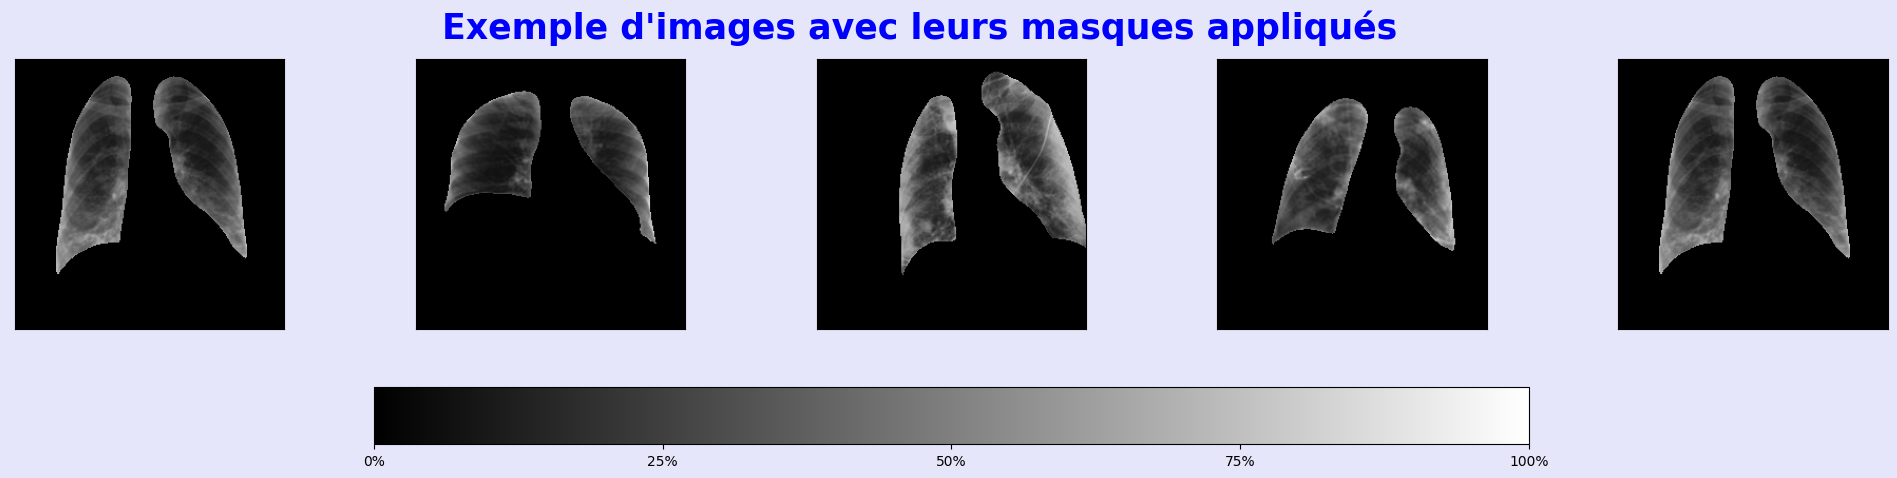

In [22]:
sow_images_with_mask("Exemple d'images avec leurs masques appliqués", img_masked, "masked")

<Figure size 4000x1000 with 0 Axes>

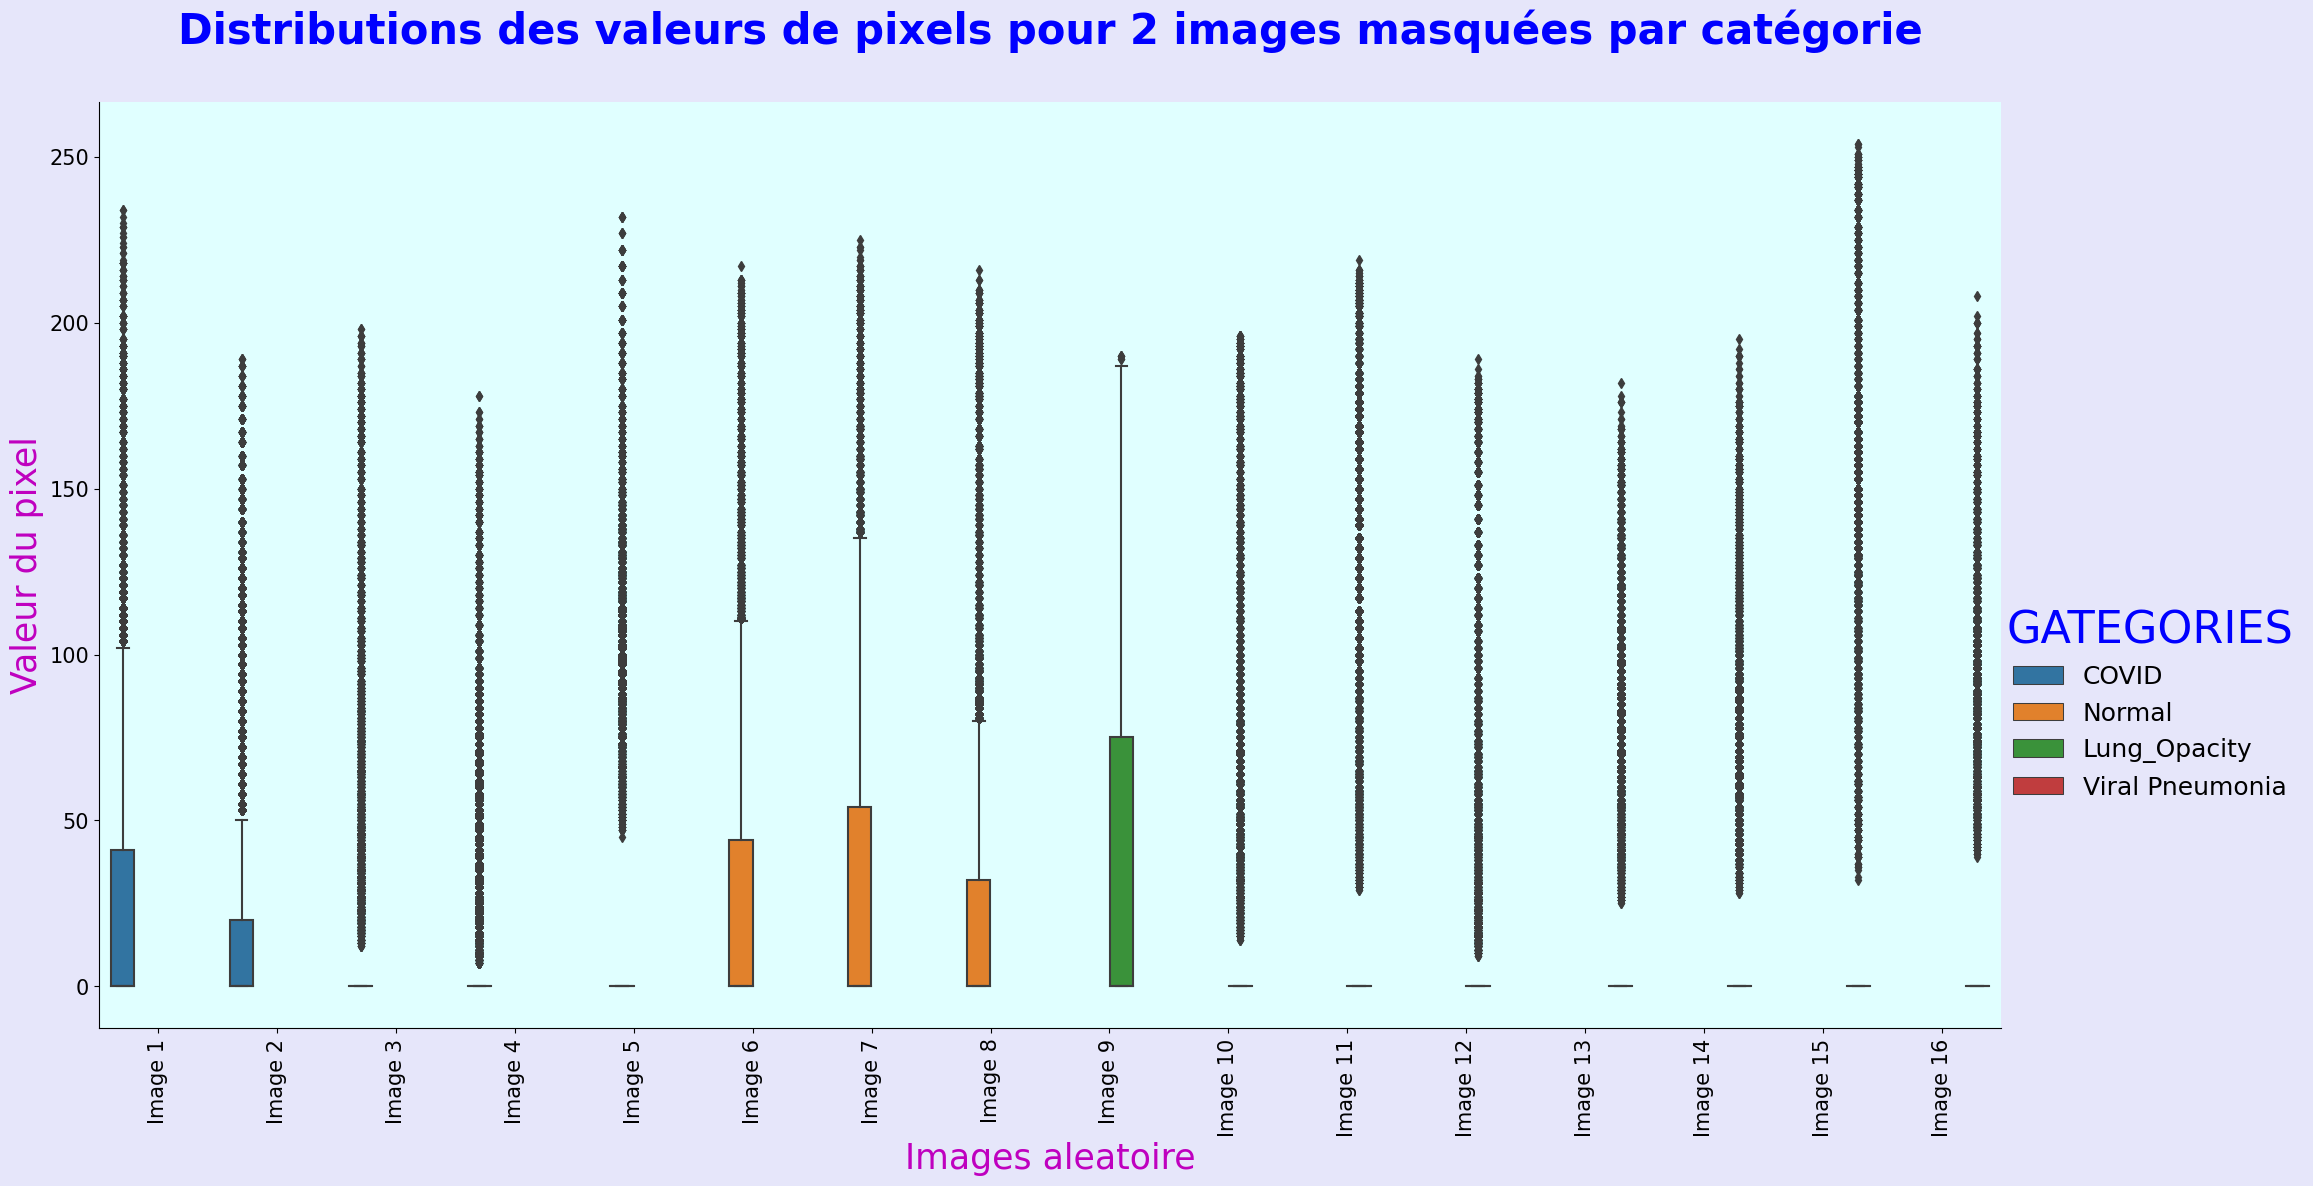

In [23]:
show_dist_pixel(img_masked, "Distributions des valeurs de pixels pour 2 images masquées par catégorie", "dist_masked", 4)

In [24]:
img_masked_norm = normalize_intensity(img_masked)

<Figure size 4000x1000 with 0 Axes>

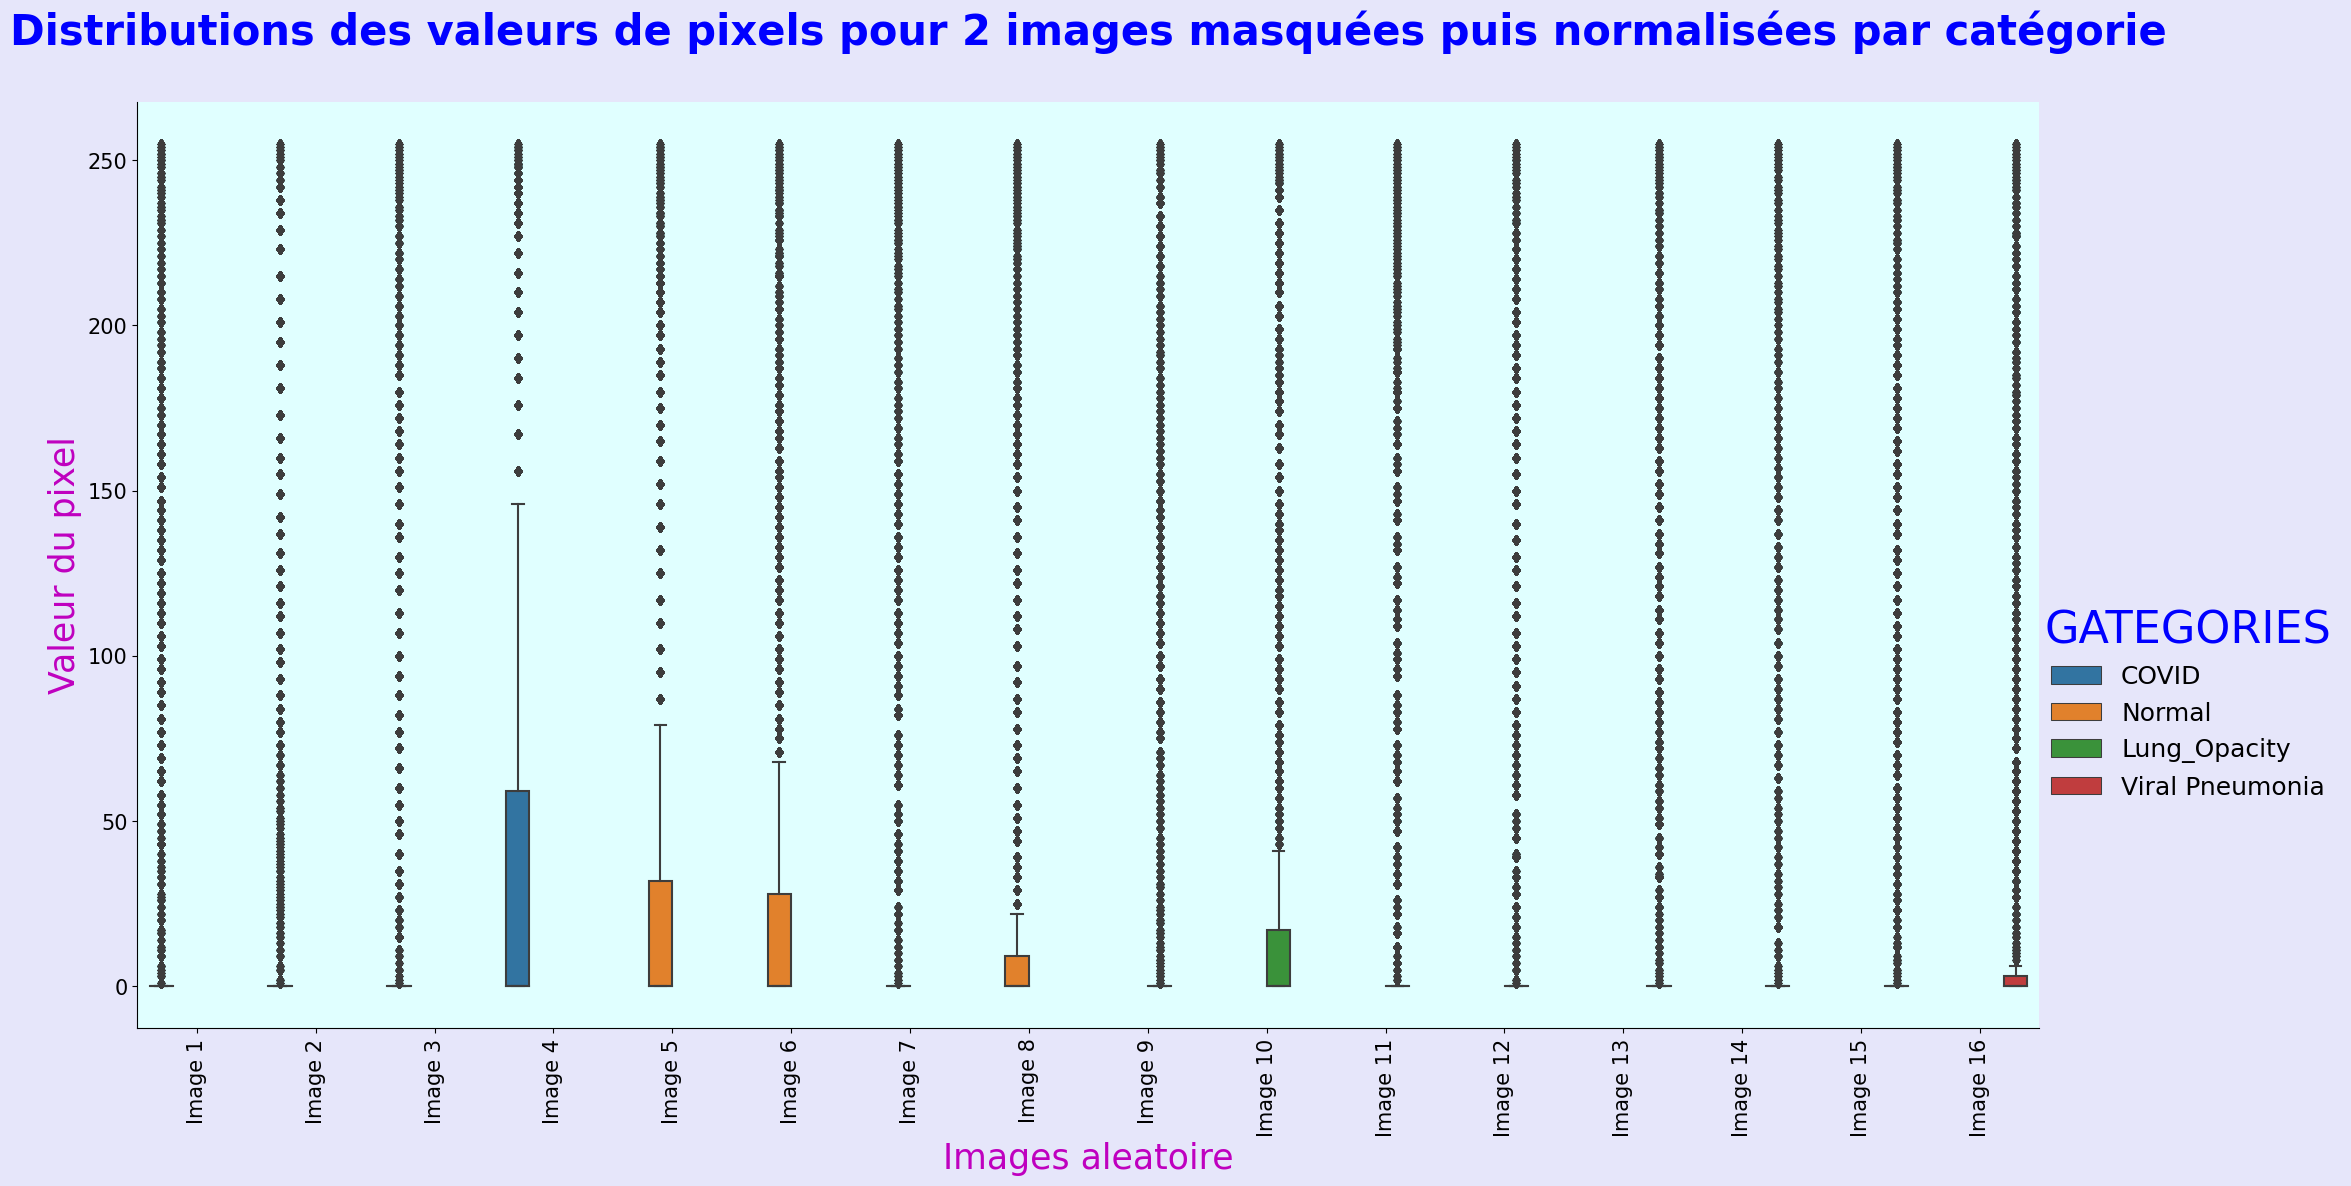

In [25]:
show_dist_pixel(img_masked_norm, "Distributions des valeurs de pixels pour 2 images masquées puis normalisées par catégorie", "dist_masked_norm", 4);

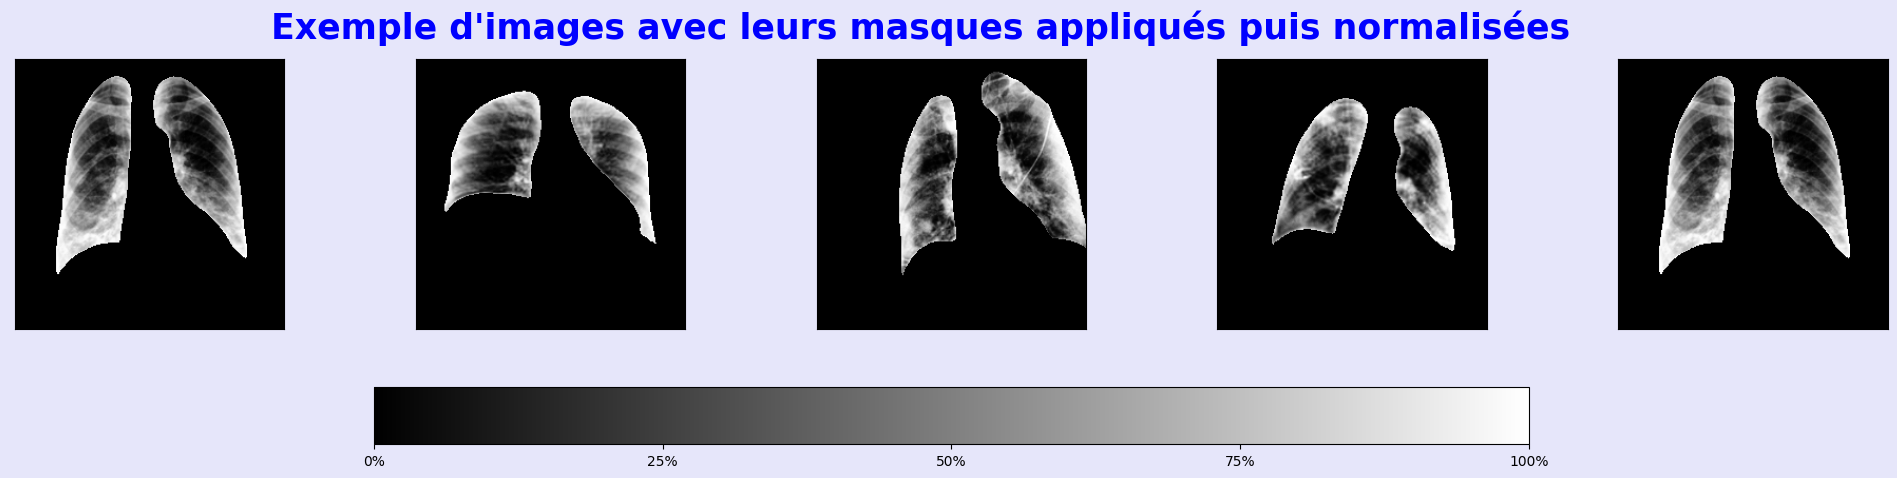

In [26]:
sow_images_with_mask("Exemple d'images avec leurs masques appliqués puis normalisées", img_masked_norm, "masked_n")

# Rendu final

categorie :  COVID


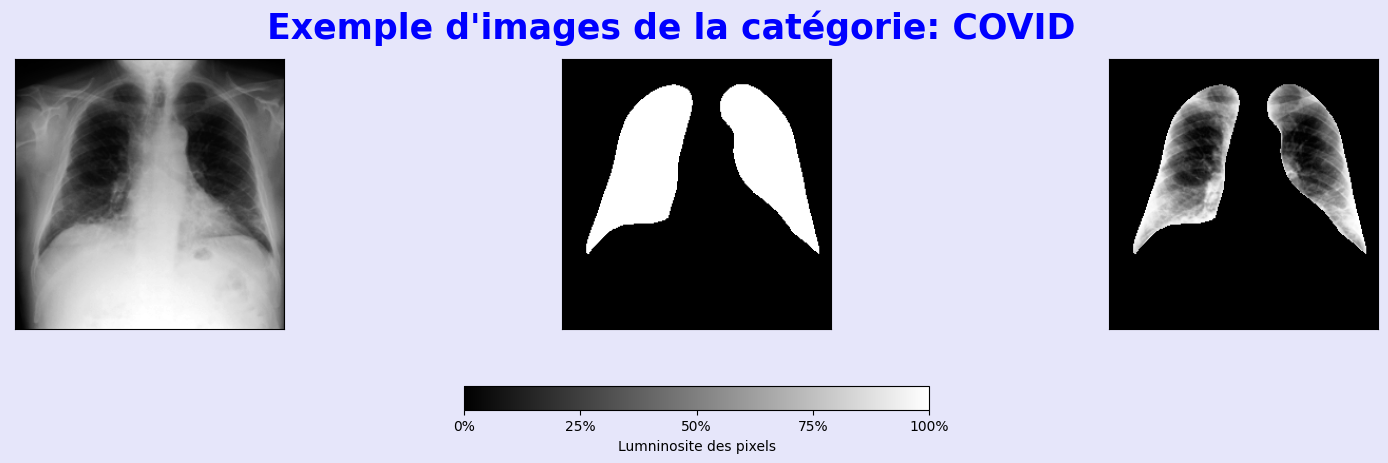

categorie :  Normal


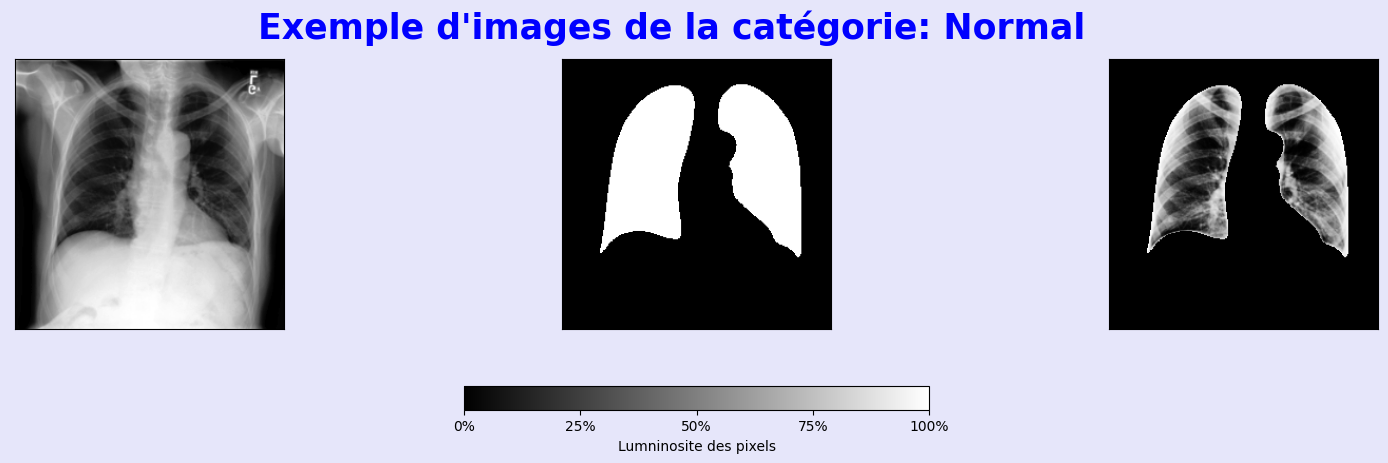

categorie :  Lung_Opacity


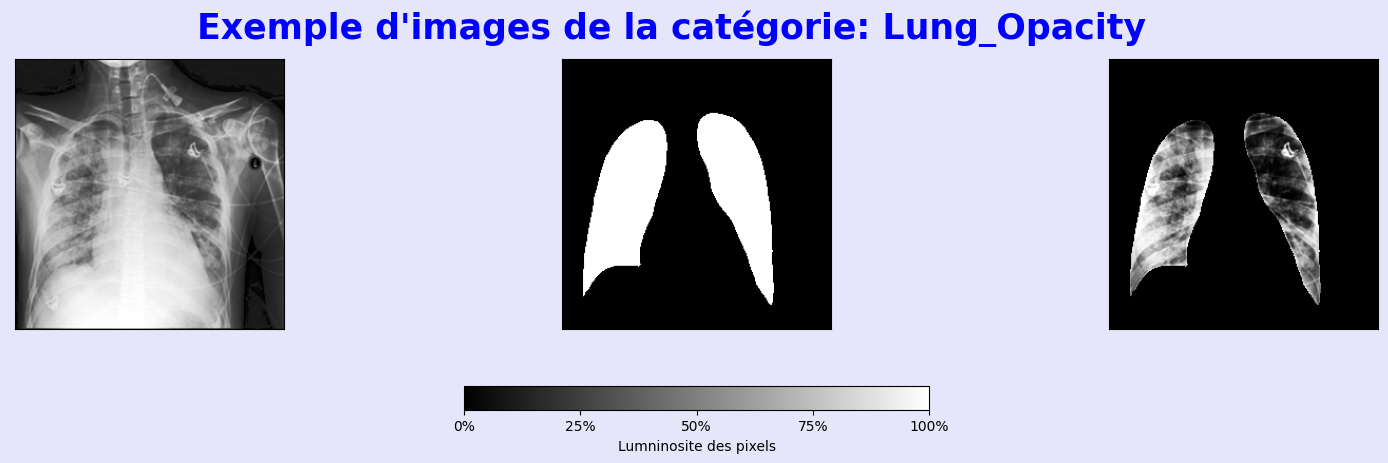

categorie :  Viral Pneumonia


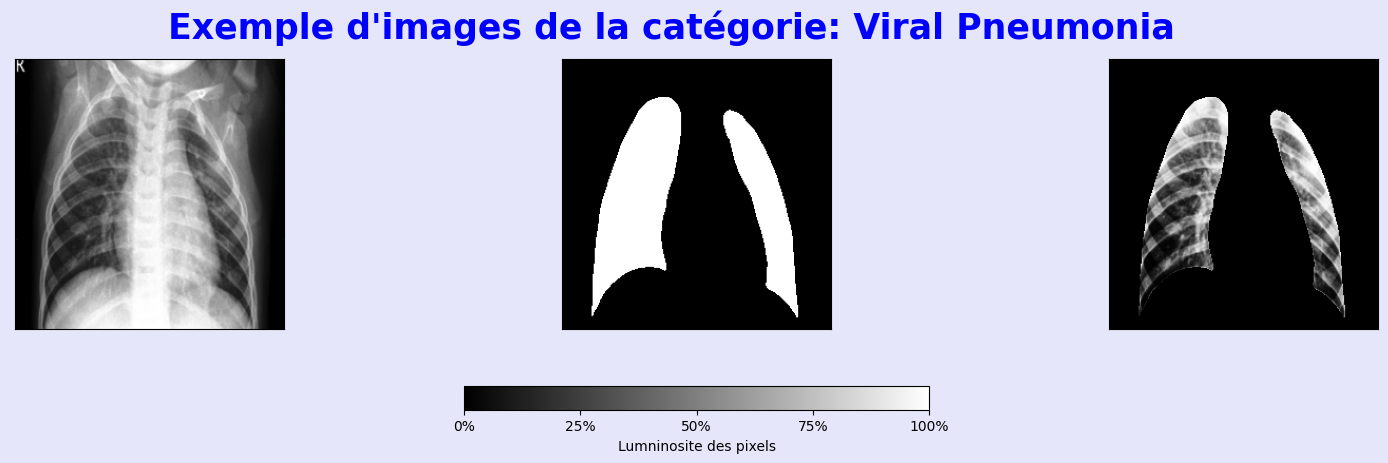

In [27]:
affichage(imgdataset_norm, maskdataset, img_masked_norm, df.labels, 1)